In [1]:
import time
import os
import sys
import ok
from imp import reload
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import dac_control as dac
import adc_control as adc
import spi_control as spi
import wupdate_control as wupdate
import neuron_control as neuron
import matmul
import nn_layers as nn
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, Input, Flatten
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import cifar10

sys.path.append('C:\\Users\\Weier Wan\\Dropbox\\cs231n\\cifar10_resnet')
from resnet_model import resnet_v1, resnet_v2
import layers_numpy as nn_np
from layer_utils import *


# Set the matplotlib default settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [2]:
# Set the DAC reference voltages
VDD = 5.0
dac.DAC_VREFS[3] = VDD
adc.C_INTEG = 1e-9

# Setup the directories
cwd = os.getcwd()
OK_DIR = os.path.dirname(cwd)
RESULTS_DIR = OK_DIR + '/data/'
PLOT_DIR = OK_DIR + '/plots/'

# Open the front panel API
dev = ok.okCFrontPanel()
print(dev.GetDeviceCount())
print(dev.GetDeviceListSerial(0))
status = dev.OpenBySerial("1743000JTJ")
print(status)
status = dev.ConfigureFPGA(OK_DIR + "/HDL/neurram_48core/neurram_top.bit")
print(status)

1
1743000JTJ
0
0


In [3531]:
# Global reset
dev.SetWireInValue(0x00, 0b11)
dev.UpdateWireIns()
dev.SetWireInValue(0x00, 0b00)
dev.UpdateWireIns()

0

In [4]:
spi.enable_single_core(dev, 6, 0)
# spi.reset(dev)
# spi.random_write(dev, True, 0, 1, 3, 1, True)
wupdate.write_reg(dev, 0, 10, 6, 0)
print(spi.spi_read(dev, [6], False, overwrite=True, shift_multiplier=2))

[[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0. 

In [4]:
die_info = np.load('die_info.npy', allow_pickle=True).item()

In [5]:
for i in range(1000):
    inp = np.random.binomial(n=2, p=0.5, size=[1,512])-1
    spi.spi_write(dev, row_addr=[0], forward=True, inputs=inp, shift_multiplier=1, pipe_in_steps=2, is_pipe_in=True)
    out = spi.spi_read(dev, row_addr=[0], num_words=32, forward=False, shift_multiplier=1, pipe_out_steps=2, is_pipe_out=True)
    if not (inp == out).all():
        print(i)
        print(inp)
        print(out)
        break

# Load CIFAR10 Dataset

In [6]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# x_train_3bit = quantize_rescale(quantize_unsigned(x_train, 3, 1.0), 3, 1.0)
# x_test_4bit = nn_np.quantize_rescale(nn_np.quantize_unsigned(x_test, 4, 0.95), 4, 0.95)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


# Load Keras Model

In [7]:
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

activation_bits = 3
model_name = 'filter16_act%db_wnoise0.20' % activation_bits

# Model name, depth and version
model_type = 'ResNet%dv%d_%s' % (depth, version, model_name)
print(model_type)

ResNet20v1_filter16_act3b_wnoise0.20


In [ ]:
K.clear_session()
input_shape = (32, 32, 3)

if version == 2:
    model = resnet_v2(input_shape=input_shape,
                      depth=depth,
                      activation_bits=activation_bits,
                      weight_noise=0.00)
else:
    model = resnet_v1(input_shape=input_shape,
                      depth=depth,
                      activation_bits=activation_bits,
                      weight_noise=0.00)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

In [ ]:
# Prepare model model saving directory.
save_dir = 'C:\\Users\\Weier Wan\\Dropbox\\cs231n\\cifar10_resnet\\model_checkpoint\\%s\\checkpoint' % model_type
latest = tf.train.latest_checkpoint(save_dir)
print(latest)
model.load_weights(latest)

In [8]:
save_dir = 'C:\\Users\\Weier Wan\\Dropbox\\cs231n\\cifar10_resnet\\model_checkpoint\\%s\\tf_savedmodel\\fwd_finetune_all_val' % model_type
model = load_model(save_dir)

In [9]:
weights = {}
for layer in model.layers:
    weights[layer.name] = layer.get_weights()

In [12]:
# Score trained model.
scores = model.evaluate(x_test_4bit, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 27s 3ms/sample - loss: 0.3745 - accuracy: 0.8782
Test loss: 0.3744501038312912
Test accuracy: 0.8782


# Forming RRAMs

In [11]:
filepath = 'C:\\Users\\Weier Wan\\Dropbox\\cs231n\\cifar10_resnet\\model_checkpoint\\ResNet20v1_filter16_act3b_wnoise0.20\\ResNet20v1_filter16_act3b_wnoise0.20_folded.npy'
params = np.load(filepath, allow_pickle=True).item()

In [3407]:
chip = 1
core_row = 4
core_col = 5
print(die_info[chip][core_row][core_col])

# core_info = die_info[chip][core_row][core_col]
# bad_rows = np.hstack([core_info['unformed'], core_info['leaky']])
# rows = np.delete(np.arange(256), bad_rows)[:]
# cols = np.arange(32)

{'unformed': [19, 33, 35, 53, 54, 63, 66, 113, 114, 122, 134, 181, 190, 226, 245, 248, 11, 184], 'leaky': [235]}


In [3404]:
die_info[chip][core_row][core_col]['unformed'] = die_info[chip][core_row][core_col]['unformed'] + [184]

In [3415]:
# chip = 1
# core_row = 2
# core_col = 5

# bad_rows = []
# bad_cols = []

# core_info = die_info[chip][core_row][core_col]
# bad_rows = np.hstack([core_info['unformed'], core_info['leaky']])
# if 'bad_cols' in core_info:
#     bad_cols = core_info['bad_cols']

rows = [208] #np.delete(np.arange(256), bad_rows)[:198]
# cols = np.delete(np.arange(256), bad_cols)[54:64]

adc.adc_setup(dev, vread=1.0, vref=0.9)
wupdate.ramp_up_voltage(dev, 3, 0, 4.2)
spi.enable_single_core(dev, core_row, core_col)
vform = np.zeros([len(rows), len(cols)])
rform = np.zeros([len(rows), len(cols)])
for ri, r in enumerate(rows):
    for ci, c in enumerate(cols):
        vform[ri, ci], rform[ri, ci] = wupdate.find_vset_bl(dev, row=r, col=c, core_row=core_row, core_col=core_col, pulse_first=True,
                                                            vset_wl=1.5, vset_bl_start=4.2, vset_bl_end=4.5, tset=1e-3, r_target=8e5, tread=4000)
        print('finished %d row, %d column' % (r, c))


Vset = 4.300000, Rset = 305687.610547
finished 208 row, 0 column
Vset = 4.200000, Rset = 28625.921501
finished 208 row, 1 column
Vset = 4.200000, Rset = 18837.352481
finished 208 row, 2 column
Vset = 4.200000, Rset = 35281.876004
finished 208 row, 3 column
Vset = 4.200000, Rset = 101811.529360
finished 208 row, 4 column
Vset = 4.200000, Rset = 19729.790623
finished 208 row, 5 column
Vset = 4.200000, Rset = 45361.920794
finished 208 row, 6 column
Vset = 4.200000, Rset = 17519.005505
finished 208 row, 7 column
Vset = 4.200000, Rset = 41963.085598
finished 208 row, 8 column
Vset = 4.200000, Rset = 16677.195863
finished 208 row, 9 column
Vset = 4.200000, Rset = 106145.888402
finished 208 row, 10 column
Vset = 4.200000, Rset = 21560.457100
finished 208 row, 11 column
Vset = 4.200000, Rset = 16494.138278
finished 208 row, 12 column
Vset = 4.200000, Rset = 22910.964157
finished 208 row, 13 column
Vset = 4.200000, Rset = 48529.425704
finished 208 row, 14 column
Vset = 4.200000, Rset = 24636.15

In [3416]:
ru = (rows[np.unique(np.where(~((rform>0) & (rform<1e6)))[0])])
print(ru)

TypeError: only integer scalar arrays can be converted to a scalar index

In [217]:
rows_unform = ru
rows_leaky = []
core = {'unformed':rows_unform, 'leaky':rows_leaky}
die_info[chip][core_row].append(core)

In [3048]:
np.save('die_info', die_info)

In [2444]:
# Find the leaky row
row_unform = 14
spi.enable_single_core(dev, core_row, core_col)
for ri in rows[38:]:
    wupdate.write_reg(dev, ri, 0, core_row, core_col)
    read1 = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                         read_cycles=2, ignore_cycles=1, verbose=False)
    wupdate.write_reg(dev, row_unform, 0, core_row, core_col)
    read_unform = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                         read_cycles=2, ignore_cycles=1, verbose=False)
    print((ri, read_unform))
    if read_unform < 1e8:
        print('Found leaky')

(40, 131730653.26633164)
(41, 132249850.22859856)
(42, 133875007.97957236)
(43, 133470294.35163097)
(44, 133194791.99745965)
(45, 134540625.50120294)
(46, 132270703.2481866)
(47, 132041681.09554541)
(49, 134174792.06653868)
(50, 132689149.0034799)
(51, 133640401.46566834)
(52, 132500521.24466921)
(53, 133768266.6241429)
(54, 133427835.21552414)
(55, 132899366.28643861)
(58, 131565370.13801765)
(59, 134024732.3853651)
(60, 134930159.24079144)
(61, 133237102.9224905)
(62, 134800064.27767962)
(63, 134735110.82557023)
(64, 134432820.51282066)
(65, 132689149.0034799)
(66, 132836231.19556604)
(67, 133512780.51886041)
(68, 131503495.84574392)
(69, 133682996.01593632)
(70, 132479595.70435885)
(71, 133427835.21552414)
(72, 133279440.73721014)
(73, 132062468.513854)
(74, 136822834.77409887)
(75, 135935958.51563773)
(76, 133491534.05474211)
(77, 133661695.34735496)
(78, 132668163.84627554)
(79, 132836231.19556619)
(80, 133682996.01593632)
(81, 134843401.38241452)
(82, 133960523.79431494)
(83, 134

In [3240]:
spi.enable_single_core(dev, core_row, core_col)

wupdate.write_reg(dev, 42, 64, core_row, core_col)
adc.adc_setup(dev, vread=1.1, vref=0.9)
reads1 = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                     read_cycles=10, ignore_cycles=5, verbose=False)
print((i, reads1))

(99, 133529782.5602496)


In [2443]:
die_info[chip][core_row][core_col]['leaky'].append(39)
np.where(rows==39)

(array([37], dtype=int64),)

In [13]:
die_info = np.load('die_info.npy', allow_pickle=True).item()

# Weight Mapping

In [220]:
weight_mapping_table_old = np.load('weight_mapping_table.npy', allow_pickle=True).item()

In [3548]:
for k in weight_mapping_table:
    for core_info in weight_mapping_table[k]:
        if core_info['chip'] == 1 and core_info['core_row'] == 0 and core_info['core_col'] == 0:
            print(k)
            print(core_info['rows'].shape)
            print(core_info['cols'].shape)

conv2d_noise_12
(196,)
(32,)


In [1162]:
g_max = 4e-5
g_min = 1e-6
g_tol = 1e-6

In [3705]:
layer = 'conv2d_noise_15'
bn_layer = 'batch_normalization_14'
relu_layer = 'activation_quant_13'

conv_W, conv_b = weights[layer]
gamma, beta, mean, variance = weights[bn_layer]
relux = weights[relu_layer][0]
conv_W, conv_b = nn.merge_conv_batchnorm(conv_W, conv_b, gamma, beta, mean, variance)

num_bias = 2
W_list = nn.conv_filter_2_matrix(conv_W, conv_b, relux, num_bias=num_bias)

print(len(W_list))

6


In [3835]:
w_index = 5
W = W_list[w_index]
G = nn.weight_mapping(W, g_max, scheme='sign', w_max_percentile=95)

# chip = 1
# core_row = 7
# core_col = 1
# core = die_info[chip][core_row][core_col]
# bad_rows = np.hstack([core['unformed'], core['leaky']])
# bad_cols = []
# if 'bad_cols' in core:
#     bad_cols = core['bad_cols']
# rows = np.delete(np.arange(256), bad_rows)[:2*W.shape[0]]
# cols = np.delete(np.arange(256), bad_cols)[:W.shape[1]]


layer_mapping = weight_mapping_table[layer][w_index]
chip = layer_mapping['chip']
core_row = layer_mapping['core_row']
core_col = layer_mapping['core_col']
rows = layer_mapping['rows']
cols = layer_mapping['cols']
print(chip)
print((core_row, core_col))
print(len(rows)/2)

1
(5, 1)
98.0


In [3439]:
core_row_1 = core_row
core_col_1 = core_col
rows_1 = rows
cols_1 = cols

In [3435]:
core_row_4 = core_row_0
core_col_4 = core_col_0
rows_4 = rows_0
cols_4 = cols_0

In [3417]:
core_row = core_row_0
core_col = core_col_0
rows = rows_0
cols = cols_0
W = W_list[4]
G = nn.weight_mapping(W, g_max, scheme='sign', w_max_percentile=95)

In [3546]:
weight_mapping_table[layer] = [{'core_row':core_row, 'core_col':core_col, 'rows':rows, 'cols':cols, 'chip':chip}]
# weight_mapping_table[layer].append({'core_row':core_row, 'core_col':core_col, 'rows':rows, 'cols':cols, 'chip':chip})
# weight_mapping_table[layer][w_index] = {'core_row':core_row, 'core_col':core_col, 'rows':rows, 'cols':cols, 'chip':chip}

In [3440]:
weight_mapping_table[layer] = [
    {'chip':chip, 'core_row':core_row_0, 'core_col':core_col_0, 'rows':rows_0, 'cols':cols_0},
    {'chip':chip, 'core_row':core_row_1, 'core_col':core_col_1, 'rows':rows_1, 'cols':cols_1},
    {'chip':chip, 'core_row':core_row_2, 'core_col':core_col_2, 'rows':rows_2, 'cols':cols_2},
    {'chip':chip, 'core_row':core_row_3, 'core_col':core_col_3, 'rows':rows_3, 'cols':cols_3},
    {'chip':chip, 'core_row':core_row_4, 'core_col':core_col_4, 'rows':rows_4, 'cols':cols_4},
    {'chip':chip, 'core_row':core_row_5, 'core_col':core_col_5, 'rows':rows_5, 'cols':cols_5}]

In [3547]:
np.save('weight_mapping_table_finetune', weight_mapping_table)

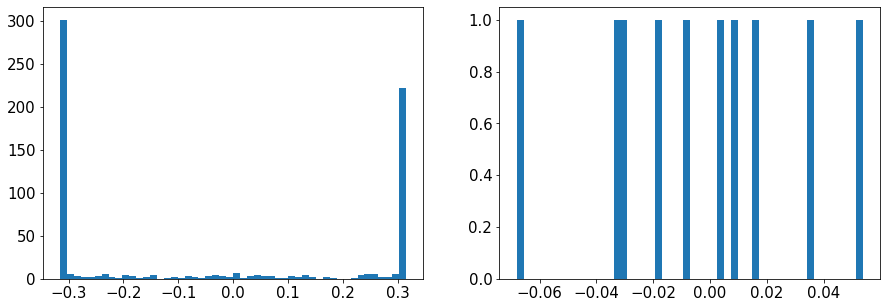

In [3447]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(W.flatten(), 50);
plt.subplot(122)
plt.hist(W[-1,:], 50);

In [916]:
# core_row = 0
# core_col = 3

spi.enable_single_core(dev, core_row, core_col)

wupdate.write_reg(dev, 11, 0, core_row, core_col)
adc.adc_setup(dev, vread=1.1, vref=0.9)
reads1 = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                     read_cycles=10, ignore_cycles=5, verbose=False)
print((i, reads1))

(499, 151440785.6730214)


In [3538]:
adc.adc_setup(dev, vread=1.1, vref=0.9)
spi.enable_single_core(dev, core_row, core_col)
wupdate.ramp_up_voltage(dev, 3, 0, 1.2)
wupdate.ramp_up_voltage(dev, 3, 1, 3.0)
wupdate.ramp_up_voltage(dev, 3, 2, 2.5)

program_sucess, G_program, num_pulses, _ = wupdate.program_array(
    dev, rows[:], cols[:], core_row, core_col, G[:, :], g_min, g_tol, 1, end_voltage=4.0, vread=1.1, vref=0.9, vset_wl=3.0, iteration_limit=50)

RRAM is programmed within the range.
Finished programming 0 row 0 col
RRAM is programmed within the range.
Finished programming 0 row 1 col
RRAM is programmed within the range.
Finished programming 0 row 2 col
RRAM is programmed within the range.
Finished programming 0 row 3 col
RRAM is programmed within the range.
Finished programming 0 row 4 col
RRAM is programmed within the range.
Finished programming 0 row 5 col
RRAM is programmed within the range.
Finished programming 0 row 6 col
RRAM is programmed within the range.
Finished programming 0 row 7 col
RRAM is programmed within the range.
Finished programming 0 row 8 col
RRAM is programmed within the range.
Finished programming 0 row 9 col
RRAM is programmed within the range.
Finished programming 1 row 0 col
RRAM is programmed within the range.
Finished programming 1 row 1 col
RRAM is programmed within the range.
Finished programming 1 row 2 col
RRAM is programmed within the range.
Finished programming 1 row 3 col
RRAM is programmed w

RRAM is programmed within the range.
Finished programming 12 row 0 col
RRAM is programmed within the range.
Finished programming 12 row 1 col
RRAM is programmed within the range.
Finished programming 12 row 2 col
RRAM is programmed within the range.
Finished programming 12 row 3 col
RRAM is programmed within the range.
Finished programming 12 row 4 col
Programming exceeds maximum iteration.
Finished programming 12 row 5 col
RRAM is programmed within the range.
Finished programming 12 row 6 col
RRAM is programmed within the range.
Finished programming 12 row 7 col
RRAM is programmed within the range.
Finished programming 12 row 8 col
RRAM is programmed within the range.
Finished programming 12 row 9 col
RRAM is programmed within the range.
Finished programming 13 row 0 col
RRAM is programmed within the range.
Finished programming 13 row 1 col
RRAM is programmed within the range.
Finished programming 13 row 2 col
RRAM is programmed within the range.
Finished programming 13 row 3 col
RRAM

RRAM is programmed within the range.
Finished programming 23 row 9 col
RRAM is programmed within the range.
Finished programming 25 row 0 col
RRAM is programmed within the range.
Finished programming 25 row 1 col
RRAM is programmed within the range.
Finished programming 25 row 2 col
RRAM is programmed within the range.
Finished programming 25 row 3 col
RRAM is programmed within the range.
Finished programming 25 row 4 col
RRAM is programmed within the range.
Finished programming 25 row 5 col
RRAM is programmed within the range.
Finished programming 25 row 6 col
RRAM is programmed within the range.
Finished programming 25 row 7 col
RRAM is programmed within the range.
Finished programming 25 row 8 col
RRAM is programmed within the range.
Finished programming 25 row 9 col
RRAM is programmed within the range.
Finished programming 26 row 0 col
RRAM is programmed within the range.
Finished programming 26 row 1 col
RRAM is programmed within the range.
Finished programming 26 row 2 col
RRAM i

RRAM is programmed within the range.
Finished programming 37 row 6 col
RRAM is programmed within the range.
Finished programming 37 row 7 col
RRAM is programmed within the range.
Finished programming 37 row 8 col
RRAM is programmed within the range.
Finished programming 37 row 9 col
RRAM is programmed within the range.
Finished programming 38 row 0 col
RRAM is programmed within the range.
Finished programming 38 row 1 col
RRAM is programmed within the range.
Finished programming 38 row 2 col
RRAM is programmed within the range.
Finished programming 38 row 3 col
RRAM is programmed within the range.
Finished programming 38 row 4 col
RRAM is programmed within the range.
Finished programming 38 row 5 col
RRAM is programmed within the range.
Finished programming 38 row 6 col
RRAM is programmed within the range.
Finished programming 38 row 7 col
RRAM is programmed within the range.
Finished programming 38 row 8 col
RRAM is programmed within the range.
Finished programming 38 row 9 col
RRAM i

RRAM is programmed within the range.
Finished programming 49 row 4 col
RRAM is programmed within the range.
Finished programming 49 row 5 col
RRAM is programmed within the range.
Finished programming 49 row 6 col
RRAM is programmed within the range.
Finished programming 49 row 7 col
RRAM is programmed within the range.
Finished programming 49 row 8 col
RRAM is programmed within the range.
Finished programming 49 row 9 col
RRAM is programmed within the range.
Finished programming 50 row 0 col
RRAM is programmed within the range.
Finished programming 50 row 1 col
RRAM is programmed within the range.
Finished programming 50 row 2 col
RRAM is programmed within the range.
Finished programming 50 row 3 col
RRAM is programmed within the range.
Finished programming 50 row 4 col
RRAM is programmed within the range.
Finished programming 50 row 5 col
RRAM is programmed within the range.
Finished programming 50 row 6 col
RRAM is programmed within the range.
Finished programming 50 row 7 col
RRAM i

RRAM is programmed within the range.
Finished programming 61 row 0 col
RRAM is programmed within the range.
Finished programming 61 row 1 col
RRAM is programmed within the range.
Finished programming 61 row 2 col
RRAM is programmed within the range.
Finished programming 61 row 3 col
RRAM is programmed within the range.
Finished programming 61 row 4 col
RRAM is programmed within the range.
Finished programming 61 row 5 col
RRAM is programmed within the range.
Finished programming 61 row 6 col
RRAM is programmed within the range.
Finished programming 61 row 7 col
RRAM is programmed within the range.
Finished programming 61 row 8 col
RRAM is programmed within the range.
Finished programming 61 row 9 col
RRAM is programmed within the range.
Finished programming 62 row 0 col
RRAM is programmed within the range.
Finished programming 62 row 1 col
RRAM is programmed within the range.
Finished programming 62 row 2 col
RRAM is programmed within the range.
Finished programming 62 row 3 col
RRAM i

RRAM is programmed within the range.
Finished programming 72 row 6 col
RRAM is programmed within the range.
Finished programming 72 row 7 col
RRAM is programmed within the range.
Finished programming 72 row 8 col
RRAM is programmed within the range.
Finished programming 72 row 9 col
RRAM is programmed within the range.
Finished programming 73 row 0 col
RRAM is programmed within the range.
Finished programming 73 row 1 col
RRAM is programmed within the range.
Finished programming 73 row 2 col
RRAM is programmed within the range.
Finished programming 73 row 3 col
RRAM is programmed within the range.
Finished programming 73 row 4 col
RRAM is programmed within the range.
Finished programming 73 row 5 col
RRAM is programmed within the range.
Finished programming 73 row 6 col
RRAM is programmed within the range.
Finished programming 73 row 7 col
RRAM is programmed within the range.
Finished programming 73 row 8 col
RRAM is programmed within the range.
Finished programming 73 row 9 col
RRAM i

RRAM is programmed within the range.
Finished programming 84 row 2 col
RRAM is programmed within the range.
Finished programming 84 row 3 col
RRAM is programmed within the range.
Finished programming 84 row 4 col
RRAM is programmed within the range.
Finished programming 84 row 5 col
RRAM is programmed within the range.
Finished programming 84 row 6 col
RRAM is programmed within the range.
Finished programming 84 row 7 col
RRAM is programmed within the range.
Finished programming 84 row 8 col
RRAM is programmed within the range.
Finished programming 84 row 9 col
RRAM is programmed within the range.
Finished programming 85 row 0 col
RRAM is programmed within the range.
Finished programming 85 row 1 col
RRAM is programmed within the range.
Finished programming 85 row 2 col
RRAM is programmed within the range.
Finished programming 85 row 3 col
RRAM is programmed within the range.
Finished programming 85 row 4 col
RRAM is programmed within the range.
Finished programming 85 row 5 col
RRAM i

RRAM is programmed within the range.
Finished programming 95 row 8 col
RRAM is programmed within the range.
Finished programming 95 row 9 col
RRAM is programmed within the range.
Finished programming 96 row 0 col
RRAM is programmed within the range.
Finished programming 96 row 1 col
RRAM is programmed within the range.
Finished programming 96 row 2 col
RRAM is programmed within the range.
Finished programming 96 row 3 col
RRAM is programmed within the range.
Finished programming 96 row 4 col
RRAM is programmed within the range.
Finished programming 96 row 5 col
RRAM is programmed within the range.
Finished programming 96 row 6 col
RRAM is programmed within the range.
Finished programming 96 row 7 col
RRAM is programmed within the range.
Finished programming 96 row 8 col
RRAM is programmed within the range.
Finished programming 96 row 9 col
RRAM is programmed within the range.
Finished programming 97 row 0 col
RRAM is programmed within the range.
Finished programming 97 row 1 col
RRAM i

RRAM is programmed within the range.
Finished programming 107 row 3 col
RRAM is programmed within the range.
Finished programming 107 row 4 col
RRAM is programmed within the range.
Finished programming 107 row 5 col
RRAM is programmed within the range.
Finished programming 107 row 6 col
RRAM is programmed within the range.
Finished programming 107 row 7 col
RRAM is programmed within the range.
Finished programming 107 row 8 col
RRAM is programmed within the range.
Finished programming 107 row 9 col
RRAM is programmed within the range.
Finished programming 108 row 0 col
RRAM is programmed within the range.
Finished programming 108 row 1 col
RRAM is programmed within the range.
Finished programming 108 row 2 col
RRAM is programmed within the range.
Finished programming 108 row 3 col
RRAM is programmed within the range.
Finished programming 108 row 4 col
RRAM is programmed within the range.
Finished programming 108 row 5 col
RRAM is programmed within the range.
Finished programming 108 ro

RRAM is programmed within the range.
Finished programming 118 row 7 col
RRAM is programmed within the range.
Finished programming 118 row 8 col
RRAM is programmed within the range.
Finished programming 118 row 9 col
RRAM is programmed within the range.
Finished programming 119 row 0 col
RRAM is programmed within the range.
Finished programming 119 row 1 col
RRAM is programmed within the range.
Finished programming 119 row 2 col
RRAM is programmed within the range.
Finished programming 119 row 3 col
RRAM is programmed within the range.
Finished programming 119 row 4 col
RRAM is programmed within the range.
Finished programming 119 row 5 col
RRAM is programmed within the range.
Finished programming 119 row 6 col
RRAM is programmed within the range.
Finished programming 119 row 7 col
RRAM is programmed within the range.
Finished programming 119 row 8 col
RRAM is programmed within the range.
Finished programming 119 row 9 col
RRAM is programmed within the range.
Finished programming 120 ro

RRAM is programmed within the range.
Finished programming 130 row 1 col
RRAM is programmed within the range.
Finished programming 130 row 2 col
RRAM is programmed within the range.
Finished programming 130 row 3 col
RRAM is programmed within the range.
Finished programming 130 row 4 col
RRAM is programmed within the range.
Finished programming 130 row 5 col
RRAM is programmed within the range.
Finished programming 130 row 6 col
RRAM is programmed within the range.
Finished programming 130 row 7 col
RRAM is programmed within the range.
Finished programming 130 row 8 col
RRAM is programmed within the range.
Finished programming 130 row 9 col
RRAM is programmed within the range.
Finished programming 131 row 0 col
RRAM is programmed within the range.
Finished programming 131 row 1 col
RRAM is programmed within the range.
Finished programming 131 row 2 col
RRAM is programmed within the range.
Finished programming 131 row 3 col
RRAM is programmed within the range.
Finished programming 131 ro

In [3539]:
print((core_row, core_col))
print(np.sum(~program_sucess)/program_sucess.size)
print(np.argwhere(~program_sucess))
print(G[~program_sucess])
print(G_program[~program_sucess])

(7, 1)
0.007692307692307693
[[  3   1]
 [ 10   3]
 [ 12   5]
 [ 95   3]
 [107   0]
 [107   4]
 [107   5]
 [107   6]
 [107   9]
 [122   3]]
[ 3.99848650e-05  3.99862038e-05 -0.00000000e+00  3.95026946e-05
  3.97327094e-05  3.96965188e-05  3.95324751e-05  2.87044932e-05
  3.97071417e-05 -0.00000000e+00]
[3.69644165e-05 2.21249390e-05 3.60469818e-06 3.10778809e-05
 1.92007446e-05 2.91110229e-05 2.17184448e-05 1.74732971e-05
 3.83840942e-05 2.86569595e-06]


# Matmul Calibration

In [3849]:
# Single Core

ITERATION = 1000
INPUT_NUM_BITS = 3
BATCH = 10
vpos = 0.79
vneg = 0.70
vreset_plus = 0.12 #0.17
vreset_minus = 0.03 #0.08
pulse_multiplier = 6
matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
spi.enable_single_core(dev, core_row, core_col)
# spi.enable_single_col(dev, core_col)
# inputs = np.floor(np.random.uniform(0, 2**INPUT_NUM_BITS, size=[ITERATION, len(rows)//2]))
inputs = input_sample[:ITERATION, 3:6, 3:6, :].reshape([ITERATION, -1])
bias = 7 * np.ones([ITERATION, num_bias])
inputs = np.hstack([inputs[:, :96], bias])
inputs_scale = nn_np.quantize_rescale(inputs, INPUT_NUM_BITS, relux)

actual_outputs = np.zeros([ITERATION, len(cols)])
expected_outputs = inputs_scale.dot(W)
start = time.time()

for i in range(ITERATION//BATCH):
    actual_outputs[BATCH*i:BATCH*(i+1), :] = matmul.matmul_unsigned(dev, inputs[BATCH*i:BATCH*(i+1), :], rows, cols, False, core_row, True, INPUT_NUM_BITS, core_col, pulse_multiplier=pulse_multiplier, prep=(i==0))

end = time.time()
print(end-start)
matmul.disable_inference(dev)

2.3787155151367188


In [3087]:
ITERATION = 1000
INPUT_NUM_BITS = 3
BATCH = 10
vreset_plus = 0.12
vreset_minus = 0.03
inputs = input_sample[:ITERATION, 3:6, 3:6, :].reshape([ITERATION, -1])
bias = 7 * np.ones([ITERATION, num_bias])
inputs = np.hstack([inputs[:, :96], bias])
inputs_scale = nn_np.quantize_rescale(inputs, INPUT_NUM_BITS, relux)

In [ ]:
vpos = 0.83
vneg = 0.75
pulse_multiplier = 8
matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)

spi.enable_single_col(dev, core_col_0, first_half=False)
# spi.enable_single_row(dev, core_row_0)

actual_outputs_0 = np.zeros([ITERATION, len(cols_0)])
actual_outputs_1 = np.zeros([ITERATION, len(cols_0)])
actual_outputs_2 = np.zeros([ITERATION, len(cols_0)])
expected_outputs_0 = inputs_scale.dot(W_list[4])
expected_outputs_1 = inputs_scale.dot(W_list[5])
# expected_outputs_2 = inputs_scale.dot(W_list[2])
start = time.time()

for i in range(ITERATION//BATCH):
    input_batch = inputs[BATCH*i:BATCH*(i+1), :]
    out_tmp = matmul.matmul_unsigned(
        dev, [[input_batch], [input_batch]], [[rows_0], [rows_1]], [[cols_0], [cols_1]], [[False], [False]],
        [core_row_0, core_row_1], True, INPUT_NUM_BITS, [core_col_0], pulse_multiplier=pulse_multiplier, prep=(i==0))
#     out_tmp = matmul.matmul_unsigned(
#         dev, [[input_batch, input_batch, input_batch]], [[rows_0, rows_1, rows_2]], [[cols_0, cols_1, cols_2]], [[False, False, False]],
#         [core_row_0], True, INPUT_NUM_BITS, [core_col_0, core_col_1, core_col_2], pulse_multiplier=pulse_multiplier, prep=(i==0))
    actual_outputs_0[BATCH*i:BATCH*(i+1), :] = out_tmp[0][0]
    actual_outputs_1[BATCH*i:BATCH*(i+1), :] = out_tmp[1][0]
#     actual_outputs_2[BATCH*i:BATCH*(i+1), :] = out_tmp[2][0]

end = time.time()
print(end-start)
matmul.disable_inference(dev)

In [3387]:
expected_outputs = expected_outputs_0
actual_outputs = actual_outputs_0

In [3850]:
slope = np.zeros(W.shape[1])
intercept = np.zeros(W.shape[1])
error = np.zeros(W.shape[1])
for c in range(W.shape[1]):
    p, res, _, _, _ = np.polyfit(expected_outputs[:, c], actual_outputs[:, c], 1, full=True)
    slope[c] = p[0]
    intercept[c] = p[1]
    actual_outputs[:, c] = (actual_outputs[:, c] - p[1]) / p[0]
    error[c] = np.sqrt(res[0]) / p[0]
print(error.mean())

4.421719553596725


In [3837]:
## expected_outputs = inputs_scale.dot(W)
expected_outputs_all = expected_outputs
actual_outputs_all = actual_outputs

In [3839]:
expected_outputs = expected_outputs_all
actual_outputs = actual_outputs_all

(0, 0.14136817260854914)
(1, 0.13128034561664023)
(2, 0.12291346434767475)
(3, 0.1468848730329933)
(4, 0.11699037596018982)
(5, 0.10463889119593603)
(6, 0.1318884546868651)
(7, 0.17369273297483193)
(8, 0.09820813574660839)
(9, 0.11740567646385823)
(10, 0.1487880006908556)
(11, 0.14609897688871284)
(12, 0.1260918154128619)
(13, 0.18436255905688625)
(14, 0.14367439142422603)
(15, 0.14487054825051696)
(16, 0.13973565488430775)
(17, 0.1324525570284889)
(18, 0.13579072840199347)
(19, 0.11236148774916917)
(20, 0.20727647055649112)
(21, 0.12849922618937845)
(22, 0.1533296948342457)
(23, 0.13187716731206364)
(24, 0.1458329849828704)
(25, 0.13584035914067571)
(26, 0.15169499414120036)
(27, 0.16828978150992666)

C:\Users\Weier Wan\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':



(28, 0.16116700251325744)
(29, 0.1669785109439907)
(30, 0.1176825764978012)
(31, 0.15536591639911712)
(32, 0.1344590461522403)
(33, 0.13505566591895204)
(34, 0.11263572914908414)
(35, 0.19173812505094567)
(36, 0.1200819600263574)
(37, 0.13776799091168207)
(38, 0.11558124275674744)
(39, 0.11445117996173726)
(40, 0.113926079469735)
(41, 0.18929387492167832)
(42, 0.12848427795005304)
(43, 0.10935183719407195)
(44, 0.12108684510149713)
(45, 0.1498909480028123)
(46, 0.12169007535167434)
(47, 0.19094114750780625)
(48, 0.1227026534286829)
(49, 0.12906951846764114)
(50, 0.09740862973898082)
(51, 0.15402037834428906)
(52, 0.17256583758607508)
(53, 0.11399012789809165)
(54, 0.11798570391532953)
(55, 0.1297520070341071)
(56, 0.13049632579419934)
(57, 0.17563377259730978)
(58, 0.10423847921157264)
(59, 0.19612212969867515)
(60, 0.14530168338177832)
(61, 0.14010115630524345)
(62, 0.11620550407956678)
(63, 0.1320180140813341)


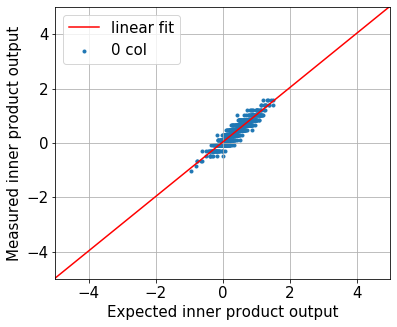

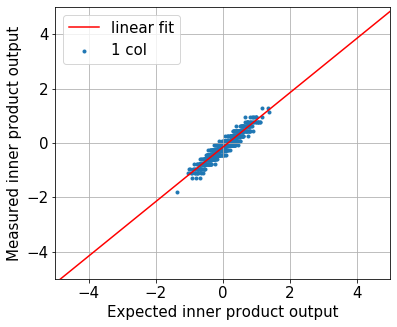

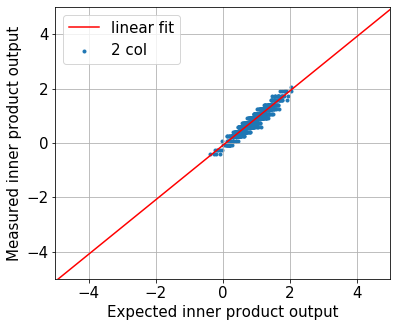

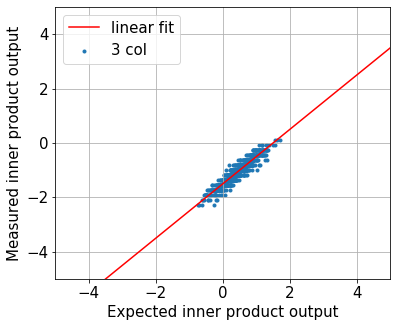

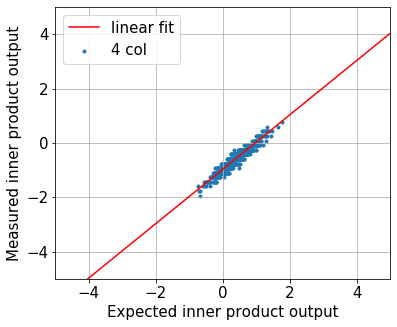

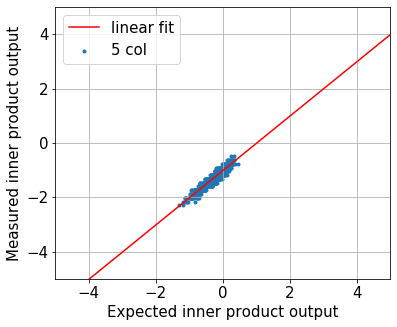

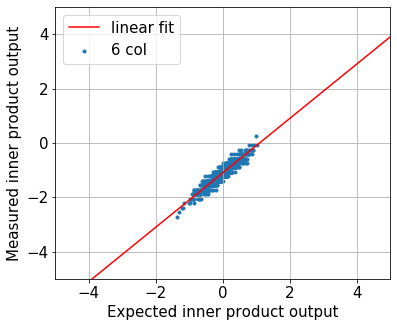

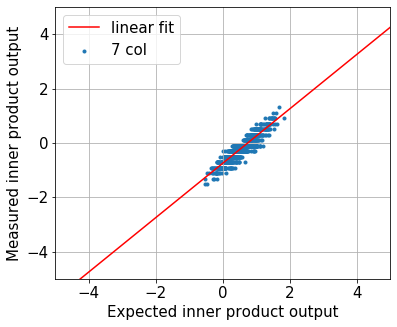

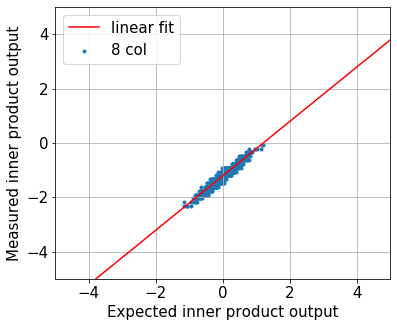

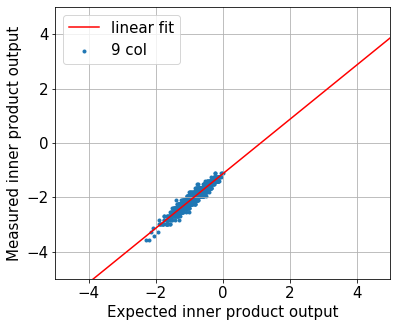

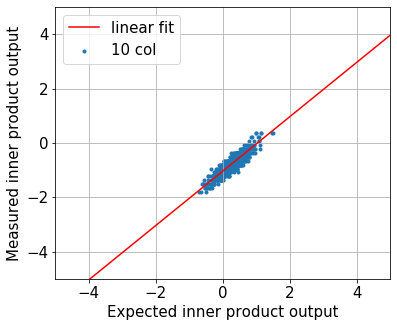

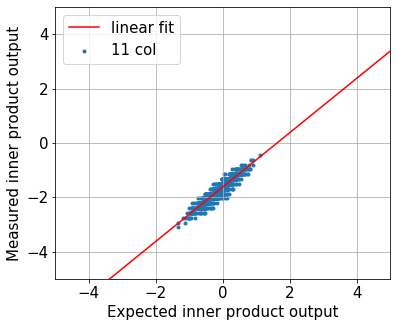

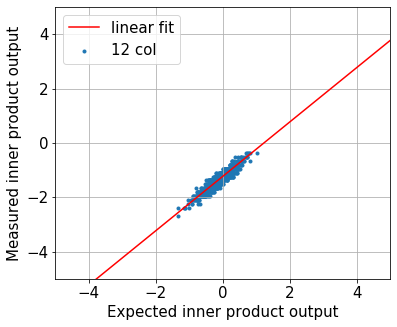

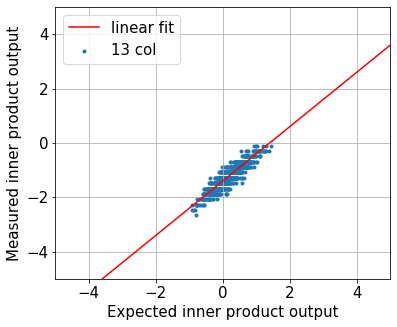

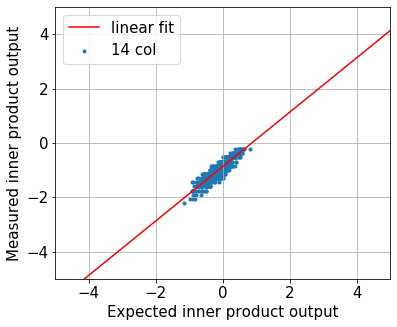

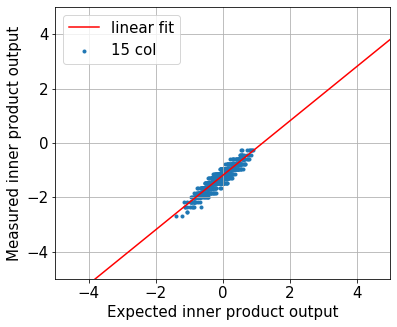

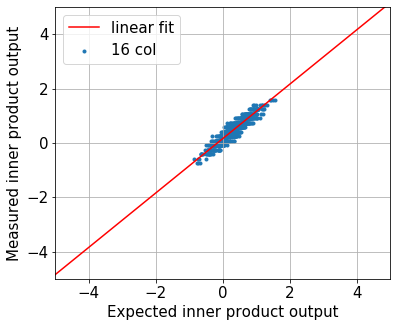

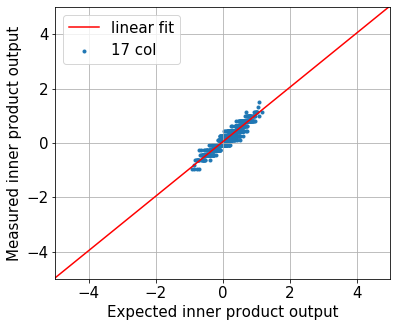

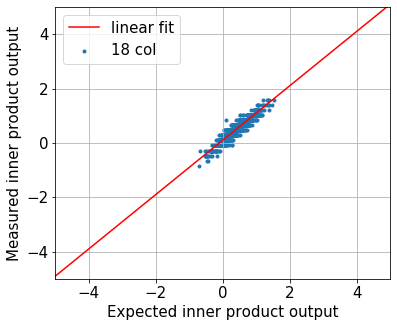

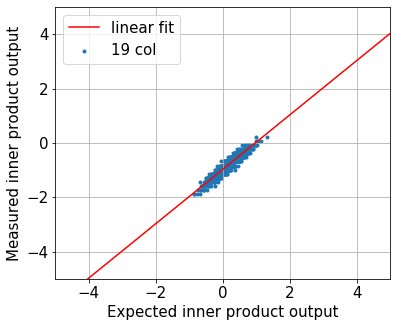

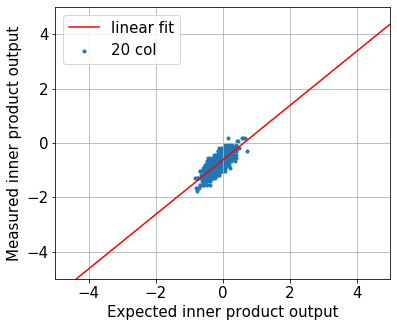

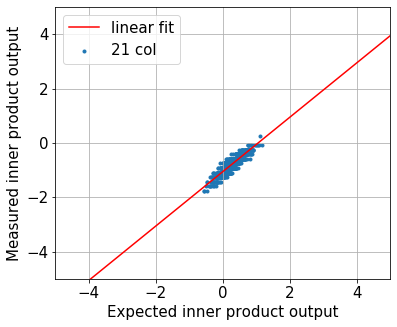

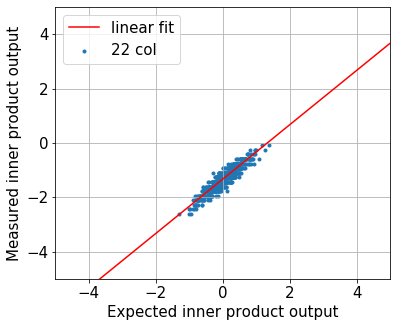

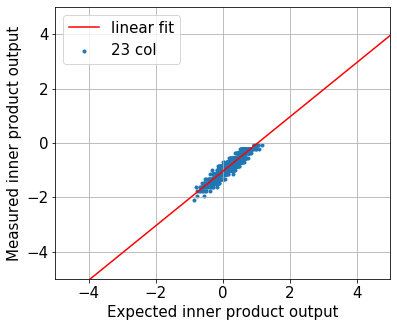

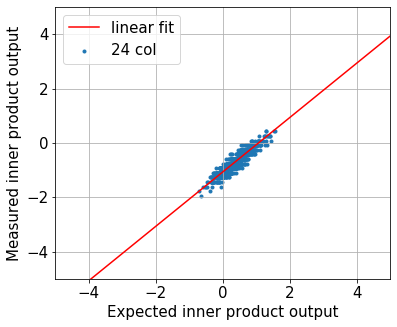

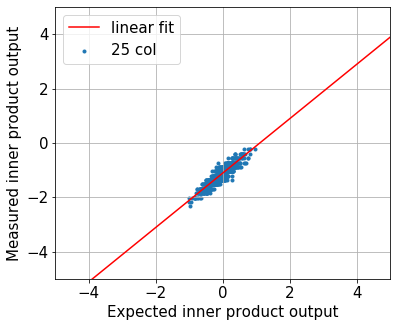

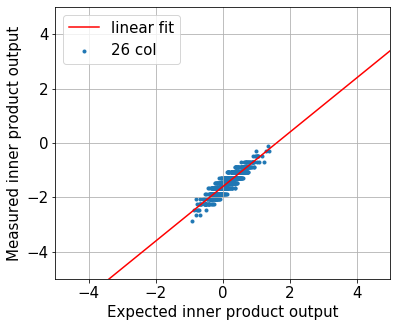

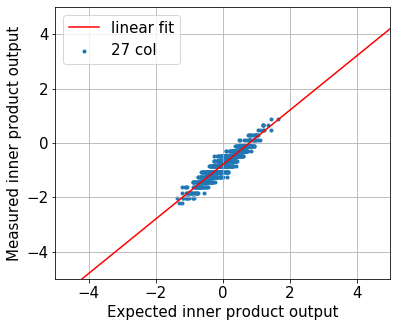

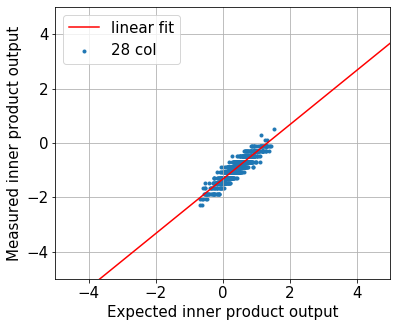

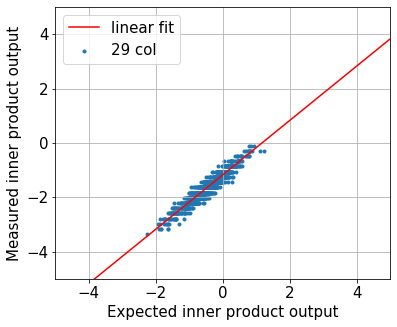

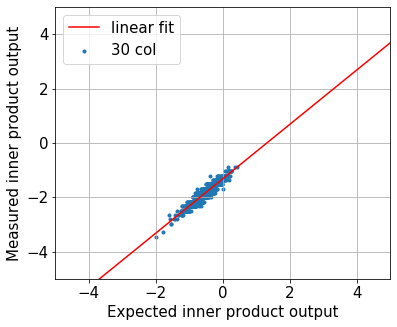

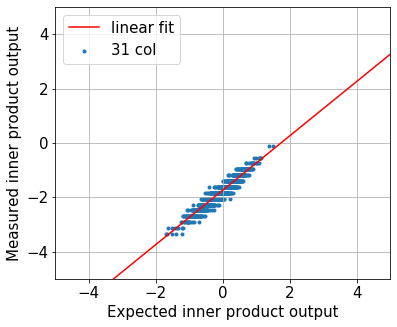

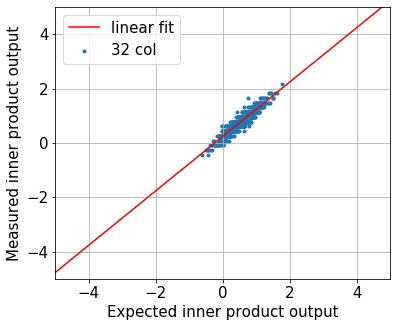

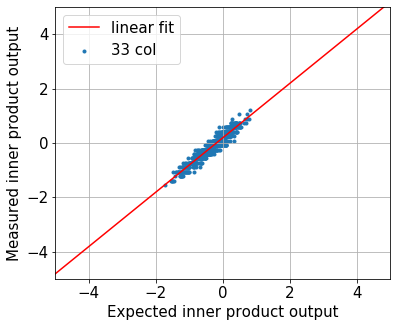

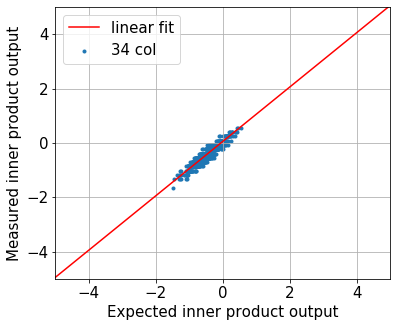

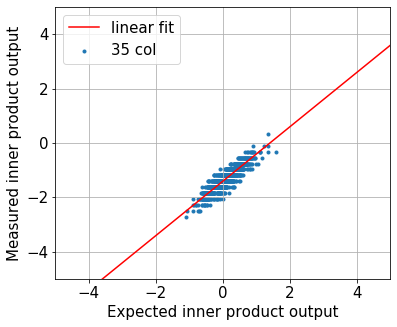

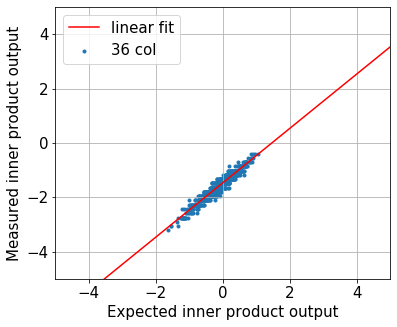

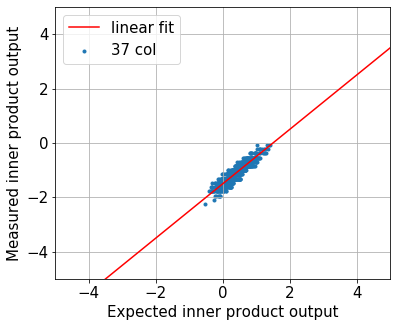

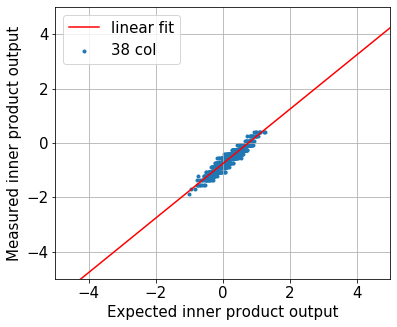

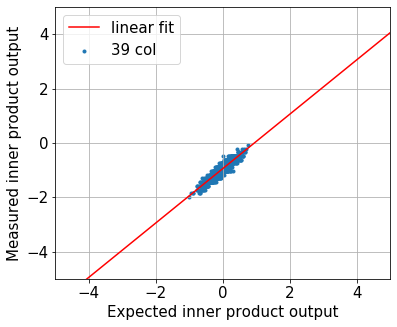

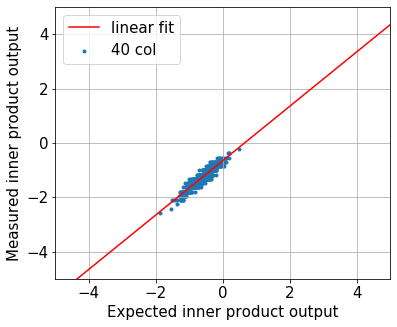

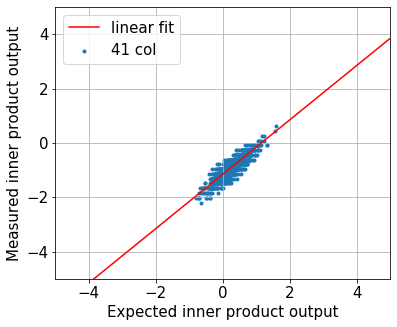

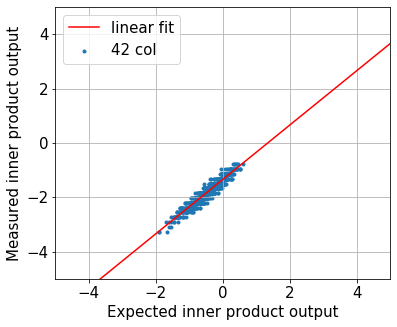

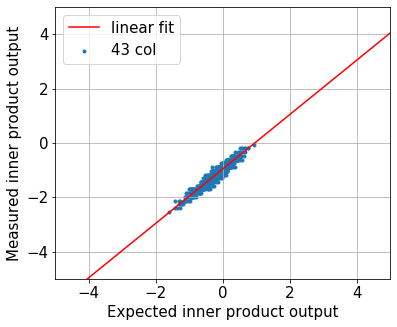

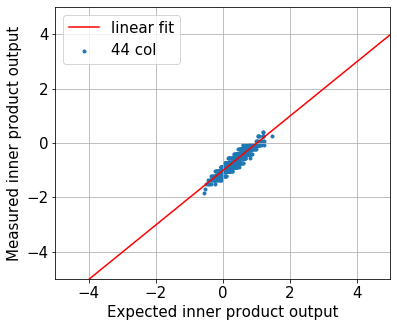

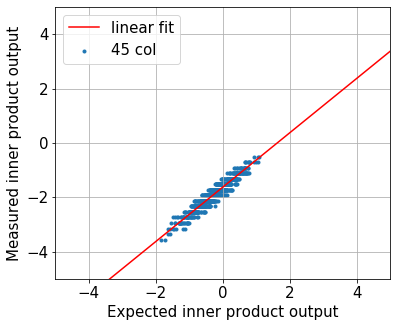

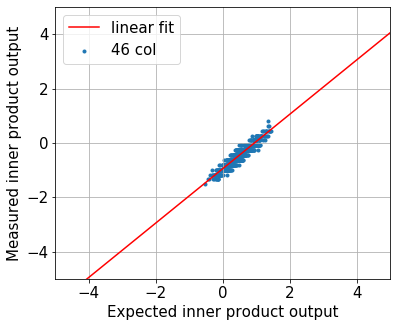

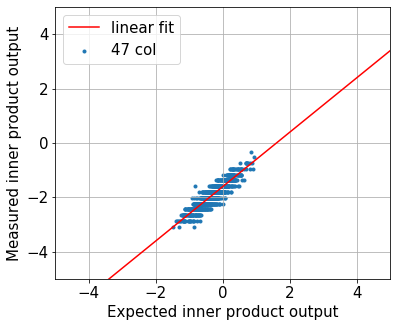

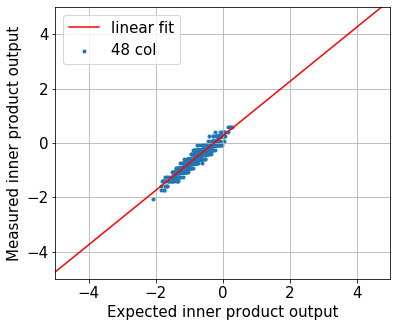

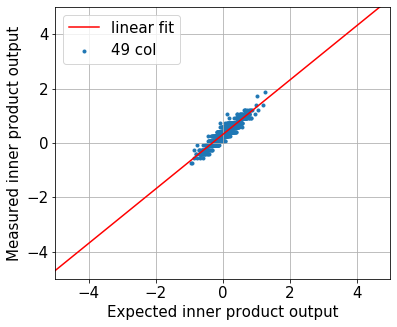

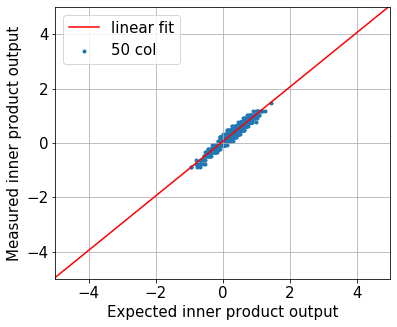

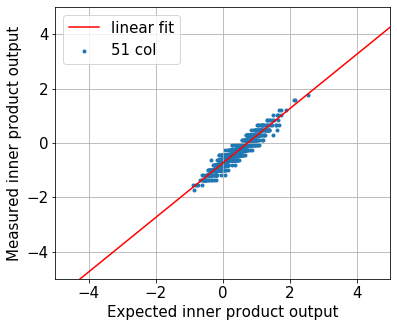

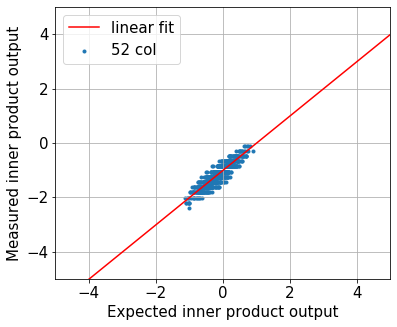

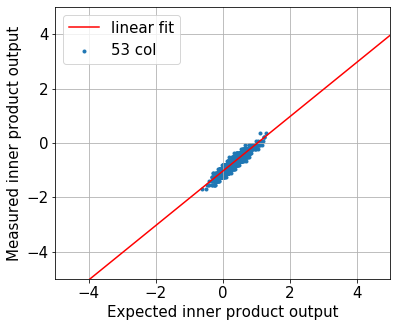

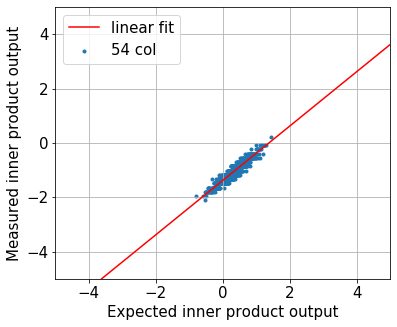

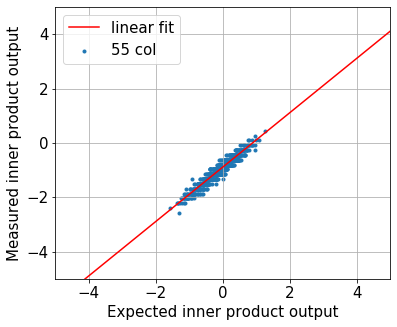

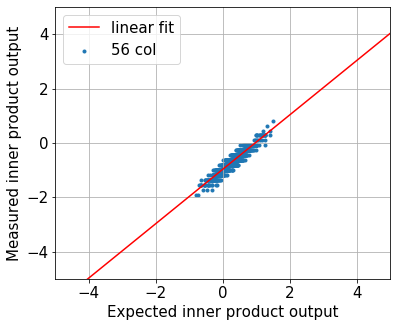

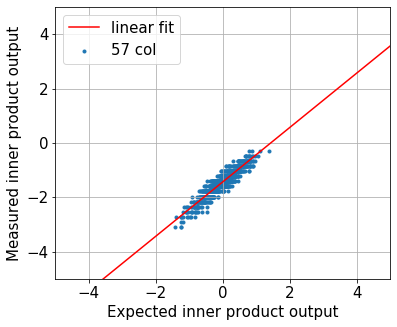

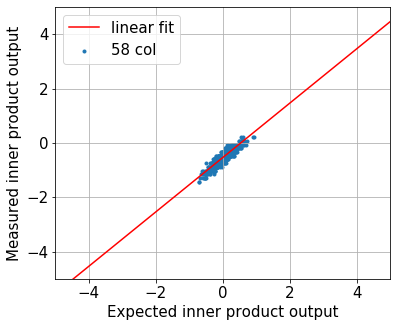

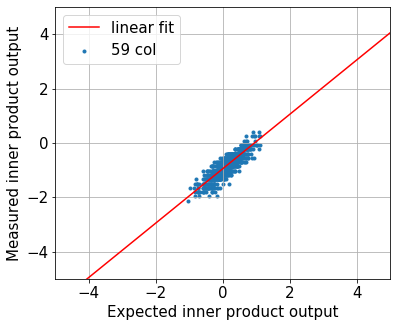

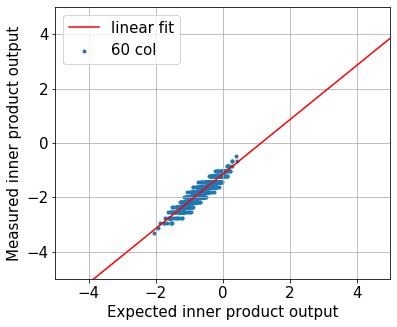

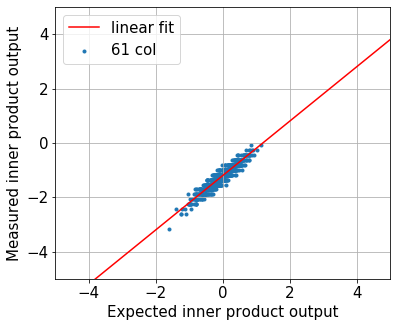

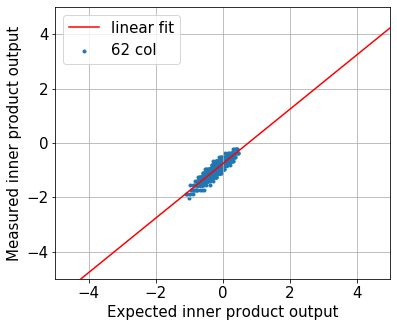

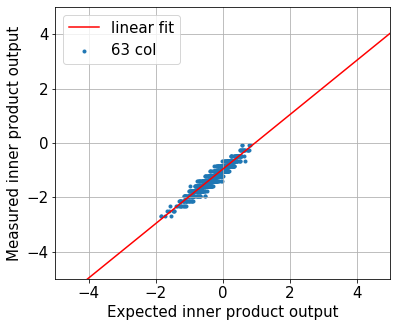

In [3838]:
for c in range(W.shape[1]):
    expected_outputs = expected_outputs_all[:, c]
    actual_outputs = actual_outputs_all[:, c]

#     expected_outputs = expected_outputs / np.linalg.norm(expected_outputs) * np.sqrt(expected_outputs.size)
    p, res, _, _, _ = np.polyfit(expected_outputs.flatten(), actual_outputs.flatten(), 1, full=True)
    y_fit = np.poly1d(p)
    std = np.sqrt(res/(expected_outputs.size-1))
    x = np.arange(-40, 40, 0.1)

    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(6,5))
    plt.scatter(expected_outputs, actual_outputs/p[0], label='%d col' % c, marker='.')
    plt.plot(x, y_fit(x)/p[0], 'r', label='linear fit')
    plt.grid()
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel('Expected inner product output')
    plt.ylabel('Measured inner product output')
    plt.legend()


#     print(p[0])
    print((c, std[0]/p[0]))

0.9603573402107676
1.024658373831548


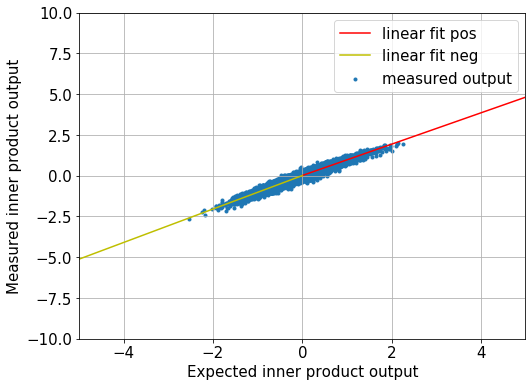

In [2679]:
# Calibrate reset voltage
linear = lambda x, k: x*k

mask_pos = expected_outputs > 0
mask_neg = ~mask_pos

p1, _, _, _, _ = np.polyfit(expected_outputs[mask_pos].flatten(), actual_outputs[mask_pos].flatten(), 1, full=True)
y_fit_1 = np.poly1d(p1)
x1 = np.linspace(0, 40, 10)

p2, _, _, _, _ = np.polyfit(expected_outputs[mask_neg].flatten(), actual_outputs[mask_neg].flatten(), 1, full=True)
y_fit_2 = np.poly1d(p2)
x2 = np.linspace(-40, 0, 10)

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
ax = plt.subplot(111)
plt.scatter(expected_outputs, actual_outputs, label='measured output', marker='.')
plt.plot(x1, y_fit_1(x1), 'r', label='linear fit pos')
plt.plot(x2, y_fit_2(x2), 'y', label='linear fit neg')
plt.grid()
plt.xlim(-5, 5)
plt.ylim(-10, 10)
plt.xlabel('Expected inner product output')
plt.ylabel('Measured inner product output')
plt.legend()

print(p1[0])
print(p2[0])

# Inference

In [3707]:
input_sample = nn_np.quantize_unsigned(out_chip_shift, 3, relux)
input_rescale = nn_np.quantize_rescale(input_sample, 3, relux)

In [3851]:
# vpos = 0.73
# vneg = 0.80
# vreset_plus = 0.17
# vreset_minus = 0.08
# pulse_multiplier = 2
w_index = 5
start = time.time()

matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
spi.enable_single_core(dev, core_row, core_col)

out_chip = nn.conv_unsigned(dev, input_sample, rows, cols, core_row, core_col, 3, 3, INPUT_NUM_BITS, segment_index=np.arange(96*w_index, 96*(w_index+1)), stride=1, pad=(1,1), bias=num_bias, batch_size=10, pulse_multiplier=pulse_multiplier, verbose=True)


# out_chip = nn.dense_unsigned(dev, input_sample, rows, cols, core_row, core_col, INPUT_NUM_BITS, bias=num_bias, batch_size=10, pulse_multiplier=pulse_multiplier, verbose=True)
# out_chip = quantize_rescale(out_chip, 3, relux1)
end = time.time()
print(end-start)

Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished batch 10
Finished batch 11
Finished batch 12
Finished batch 13
Finished batch 14
Finished batch 15
Finished batch 16
Finished batch 17
Finished batch 18
Finished batch 19
Finished batch 20
Finished batch 21
Finished batch 22
Finished batch 23
Finished batch 24
Finished batch 25
Finished batch 26
Finished batch 27
Finished batch 28
Finished batch 29
Finished batch 30
Finished batch 31
Finished batch 32
Finished batch 33
Finished batch 34
Finished batch 35
Finished batch 36
Finished batch 37
Finished batch 38
Finished batch 39
Finished batch 40
Finished batch 41
Finished batch 42
Finished batch 43
Finished batch 44
Finished batch 45
Finished batch 46
Finished batch 47
Finished batch 48
Finished batch 49
Finished batch 50
Finished batch 51
Finished batch 52
Finished batch 53
Finished batch 54
Finished batch 55
Fi

Finished batch 437
Finished batch 438
Finished batch 439
Finished batch 440
Finished batch 441
Finished batch 442
Finished batch 443
Finished batch 444
Finished batch 445
Finished batch 446
Finished batch 447
Finished batch 448
Finished batch 449
Finished batch 450
Finished batch 451
Finished batch 452
Finished batch 453
Finished batch 454
Finished batch 455
Finished batch 456
Finished batch 457
Finished batch 458
Finished batch 459
Finished batch 460
Finished batch 461
Finished batch 462
Finished batch 463
Finished batch 464
Finished batch 465
Finished batch 466
Finished batch 467
Finished batch 468
Finished batch 469
Finished batch 470
Finished batch 471
Finished batch 472
Finished batch 473
Finished batch 474
Finished batch 475
Finished batch 476
Finished batch 477
Finished batch 478
Finished batch 479
Finished batch 480
Finished batch 481
Finished batch 482
Finished batch 483
Finished batch 484
Finished batch 485
Finished batch 486
Finished batch 487
Finished batch 488
Finished bat

Finished batch 869
Finished batch 870
Finished batch 871
Finished batch 872
Finished batch 873
Finished batch 874
Finished batch 875
Finished batch 876
Finished batch 877
Finished batch 878
Finished batch 879
Finished batch 880
Finished batch 881
Finished batch 882
Finished batch 883
Finished batch 884
Finished batch 885
Finished batch 886
Finished batch 887
Finished batch 888
Finished batch 889
Finished batch 890
Finished batch 891
Finished batch 892
Finished batch 893
Finished batch 894
Finished batch 895
Finished batch 896
Finished batch 897
Finished batch 898
Finished batch 899
Finished batch 900
Finished batch 901
Finished batch 902
Finished batch 903
Finished batch 904
Finished batch 905
Finished batch 906
Finished batch 907
Finished batch 908
Finished batch 909
Finished batch 910
Finished batch 911
Finished batch 912
Finished batch 913
Finished batch 914
Finished batch 915
Finished batch 916
Finished batch 917
Finished batch 918
Finished batch 919
Finished batch 920
Finished bat

In [3420]:
# Inference Multi-core
start = time.time()

matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)

group_size = 100
num_steps = input_sample.shape[0] // group_size
out_chip = np.zeros([2, 1, input_sample.shape[0], 8, 8, 64], dtype=np.float16)
spi.enable_single_col(dev, core_col_0, first_half=False)
for s in range(num_steps):
    out_chip[:, :, s*group_size : (s+1)*group_size, :, :, :] = nn.conv_unsigned(
        dev, input_sample[s*group_size : (s+1)*group_size], [[rows_0], [rows_1]], [[cols_0], [cols_1]], [core_row_0, core_row_1], [core_col_0], 3, 3, INPUT_NUM_BITS, 
        segment_index=[[np.arange(96*4, 96*5)], [np.arange(96*5, 96*6)]], stride=1, pad=(1,1), bias=[[num_bias], [num_bias]], batch_size=10, pulse_multiplier=pulse_multiplier, verbose=True)
    print('Finished group %d' % s)
    
end = time.time()
print(end-start)

Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 0
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 1
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 2
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 3
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 4
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch

Finished batch 7
Finished batch 8
Finished batch 9
Finished group 43
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 44
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 45
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 46
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 47
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished 

Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 87
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 88
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 89
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 90
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 91
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished 

In [3340]:
np.save(DATA_PATH + 'out_chip_tmp_1', out_chip)

In [3852]:
# w_index = 1
intermediate_output = nn_np.conv(input_rescale[:2000], conv_W, conv_b/6, stride=1, pad=(1,1),
                                 segment_index=np.arange(96*w_index, 96*(w_index+1)), bias=True)
# intermediate_output = nn_np.dense(input_rescale[:2000], conv_W, conv_b, segment_index=None)

In [3853]:
# fit_sample = np.hstack([np.arange(2000), np.arange(25000, 27000), np.arange(48000, 50000)])
slope = np.zeros(W.shape[1], dtype=np.float32)
intercept = np.zeros(W.shape[1], dtype=np.float32)
out_chip_shift = np.copy(out_chip[:2000, :, :, :]).astype(np.float32)
for c in range(W.shape[1]):
    p, res, _, _, _ = np.polyfit(intermediate_output[:, :, :, c].flatten().astype(np.float32), out_chip_shift[:, :, :, c].flatten().astype(np.float32), 1, full=True)
    std = np.sqrt(res/(intermediate_output[:, :, :, c].size-1))
    print(p[0])
    print(std[0]/p[0])
    slope[c] = p[0]
    intercept[c] = p[1]
    out_chip_shift[:, :, :, c] = (out_chip_shift[:, :, :, c] - p[1]) / p[0]

5.2997973750632985
0.13231696040653013
6.212866933970598
0.12594188094648784
5.749414150343841
0.13142657341273176
5.608078443123391
0.1296802621442568
5.987252402569999
0.1167145047400149
7.226559963220629
0.10411649693958785
5.79247701944703
0.129202928173066
5.160058906648459
0.1591186989798167
6.954028321092545
0.10068252512669565
5.81196167740639
0.12170375374938341
7.251442240621135
0.13901392342223845
5.324449713143931
0.1439584138260179
6.371000618404639
0.13338723615911138
5.250206494835286
0.15766770454855192
6.385495395625921
0.13904012445089323
5.863425715271659
0.1374074376062867
5.953460657371687
0.13867559588625314
5.823891635721609
0.13231300381186148
5.271153888566659
0.1353951629872078
6.607146562782119
0.11151934106724953
9.096372441257756
0.1874872085066648
6.180741342219304
0.126268112355333
5.367018934385876
0.15769129505038904
6.1557690176053965
0.12658116577904852
5.812938470968415
0.13315292908874402
5.50118931674067
0.1485868657556281
4.675775048909908
0.15354

C:\Users\Weier Wan\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


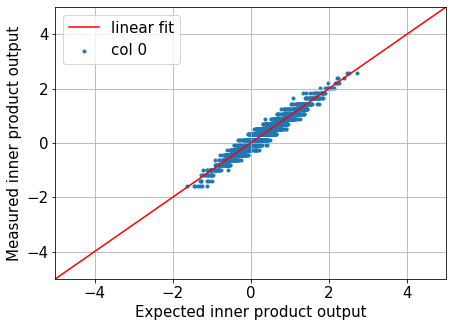

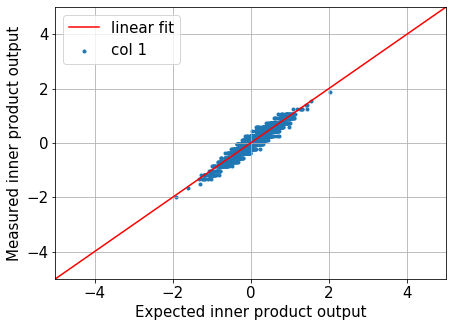

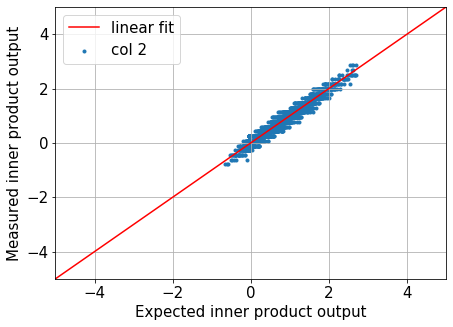

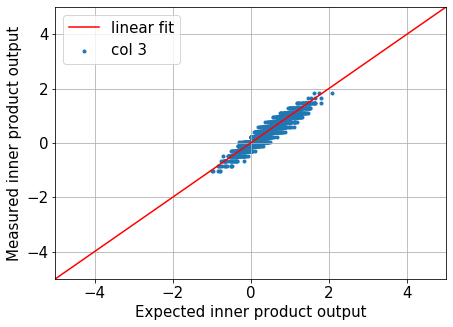

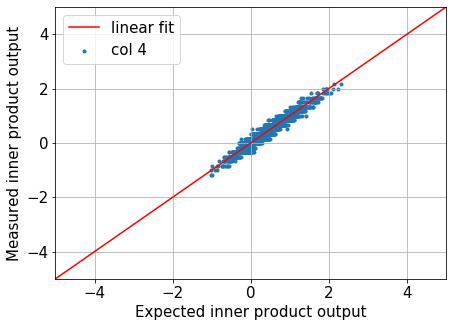

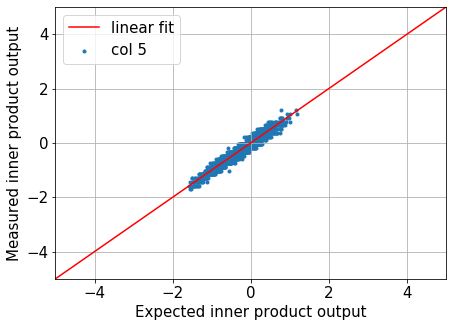

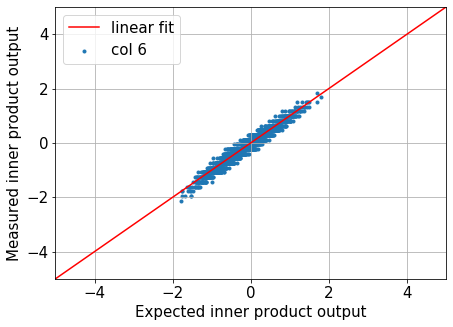

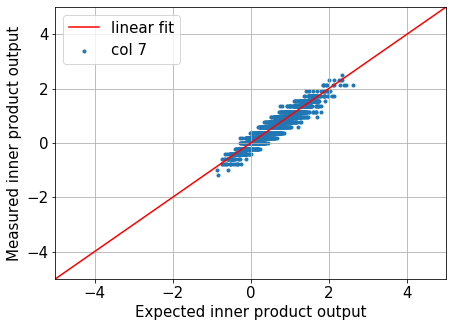

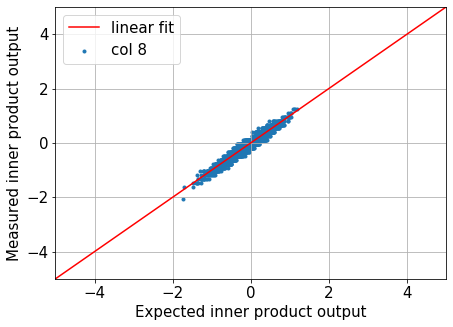

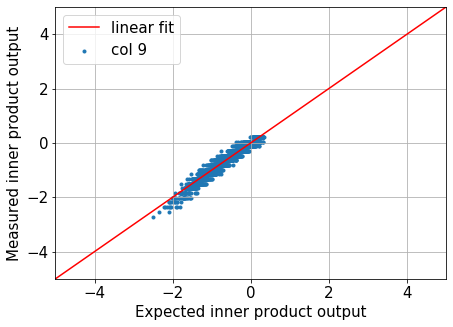

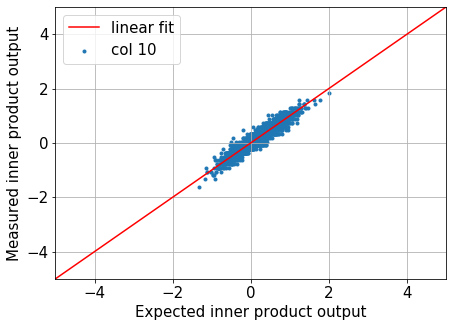

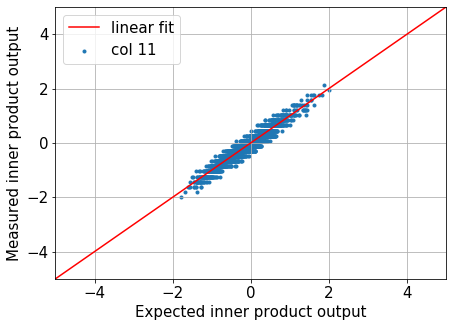

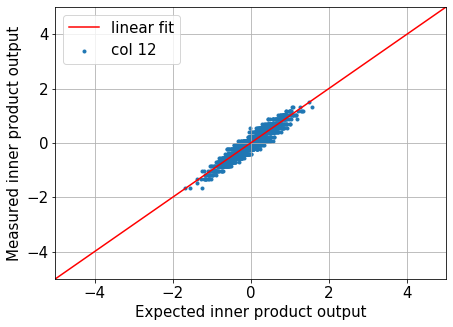

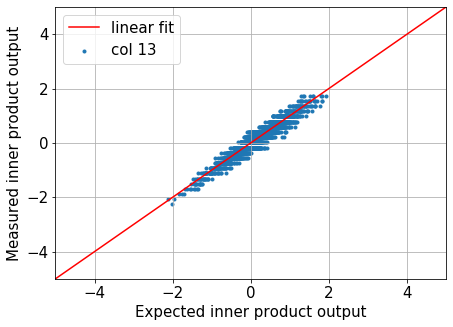

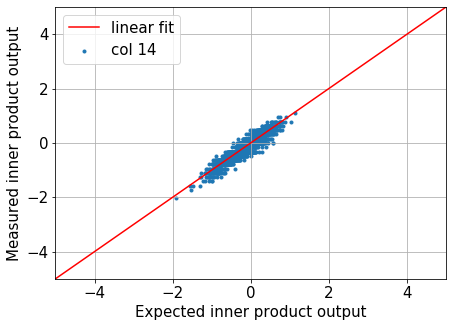

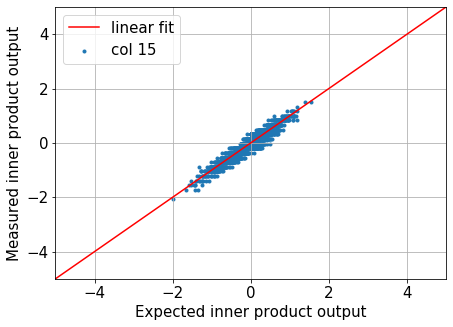

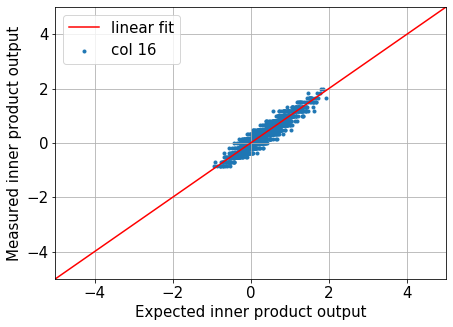

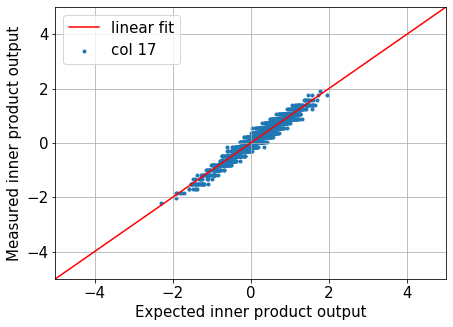

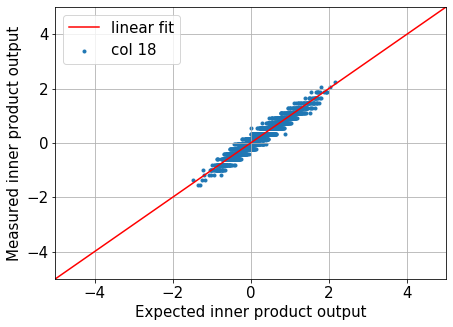

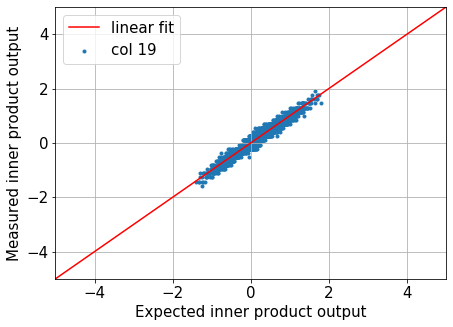

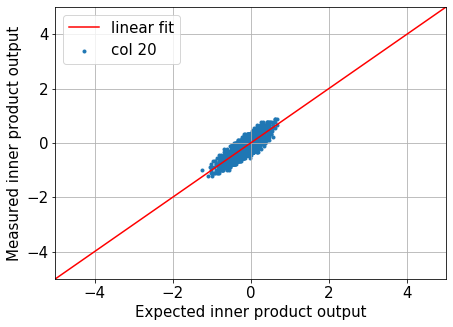

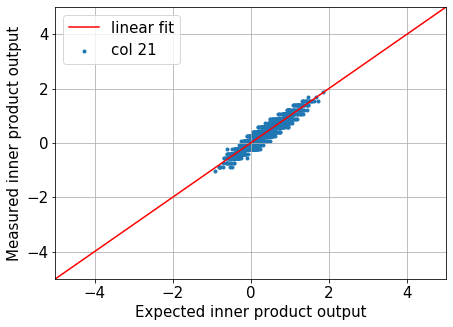

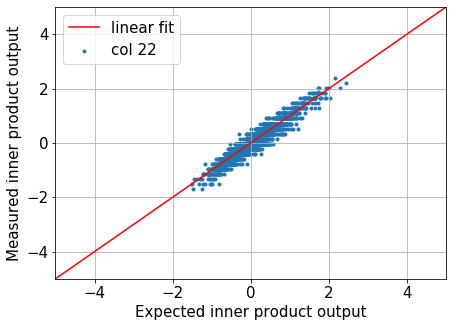

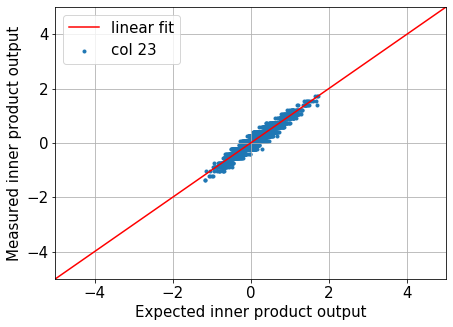

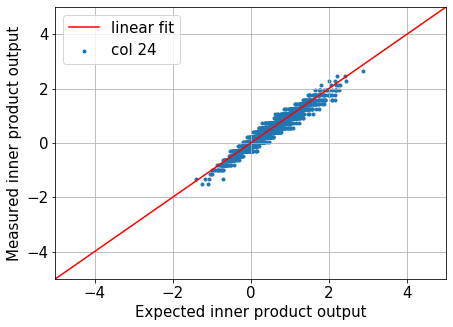

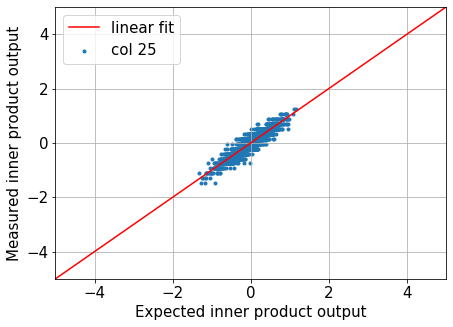

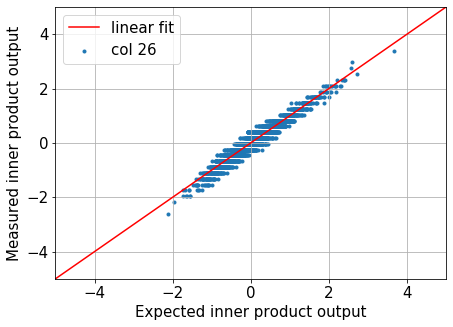

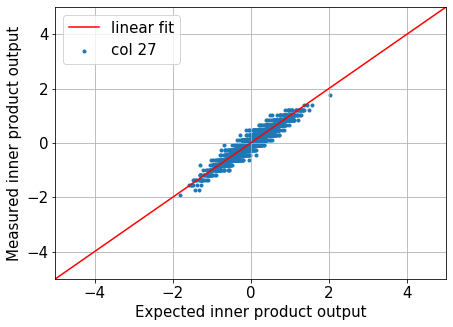

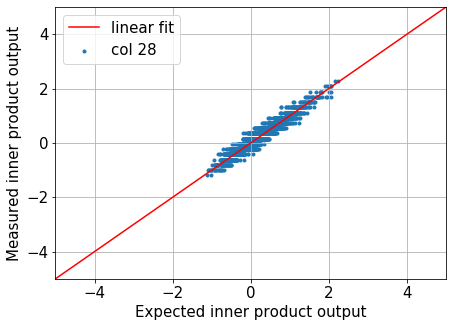

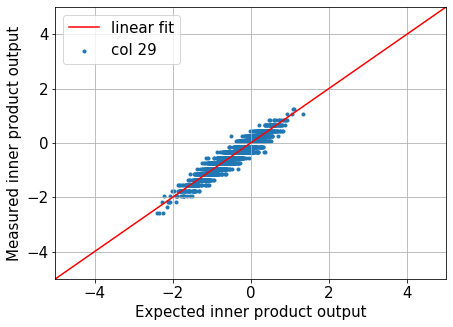

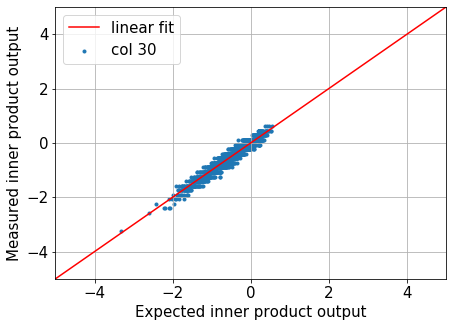

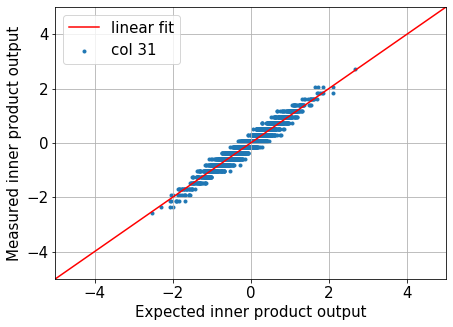

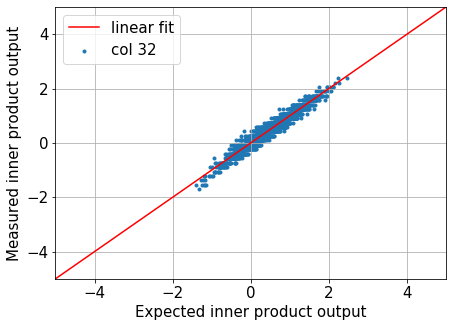

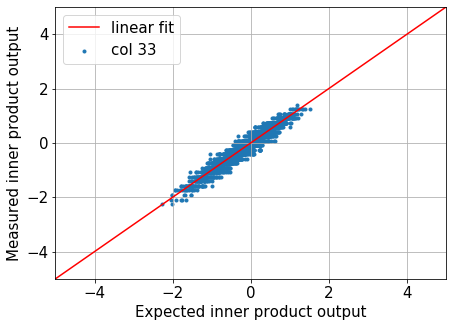

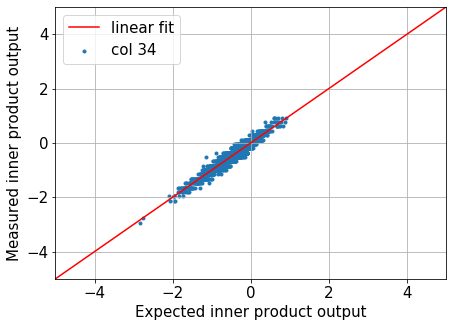

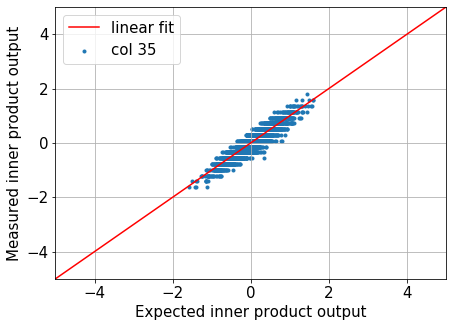

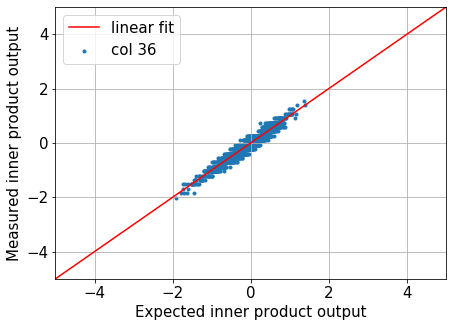

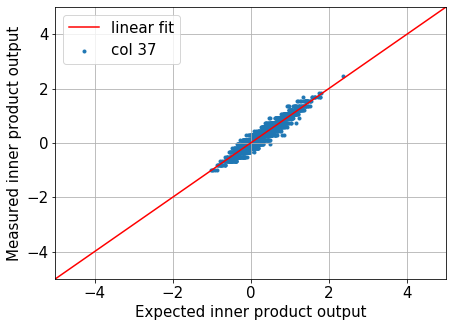

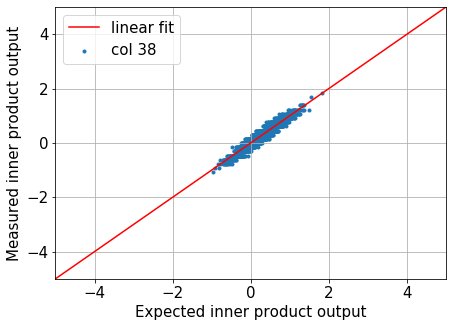

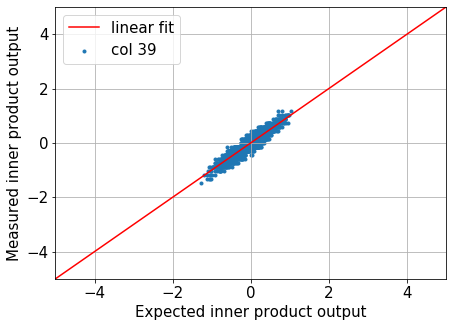

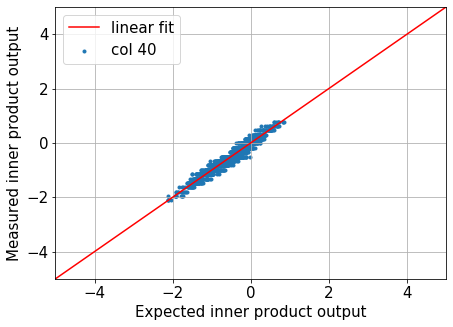

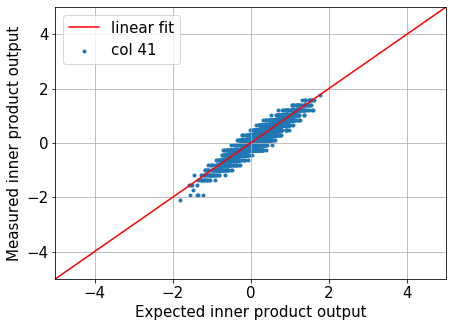

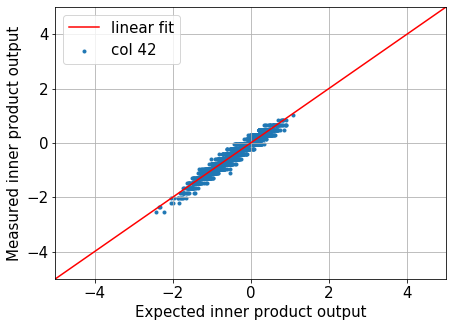

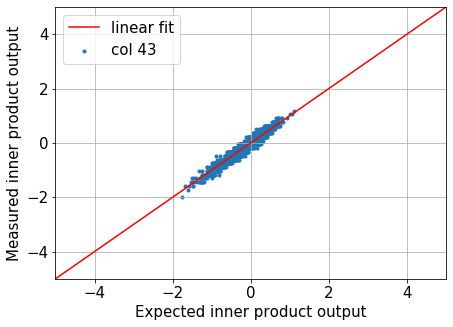

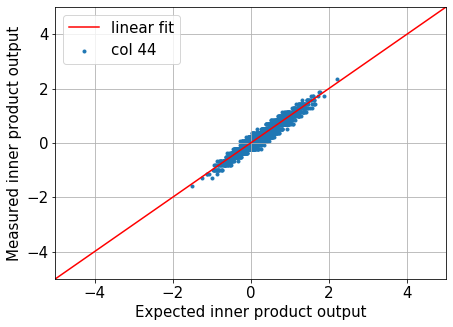

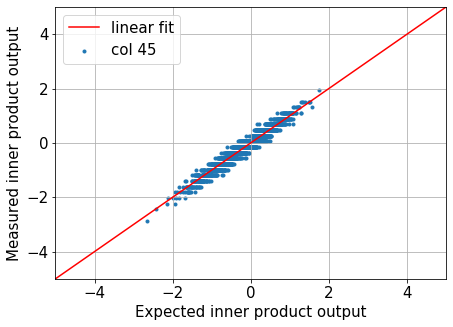

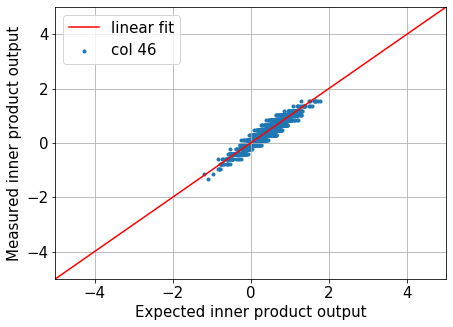

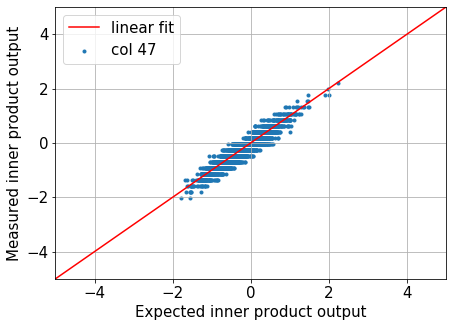

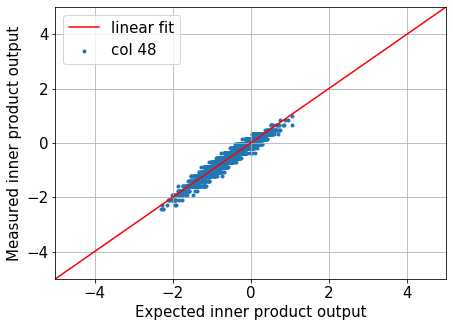

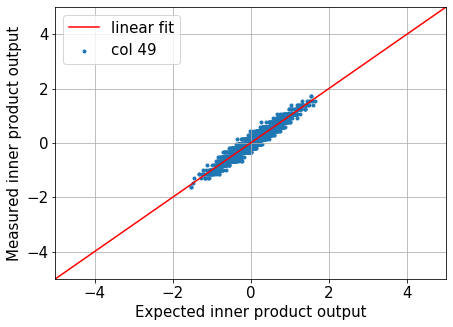

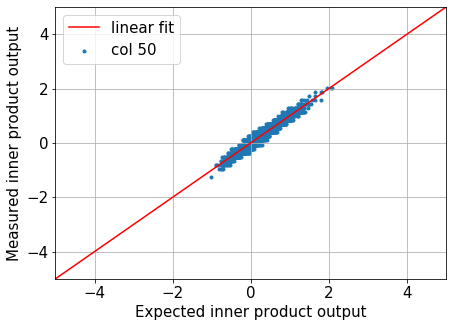

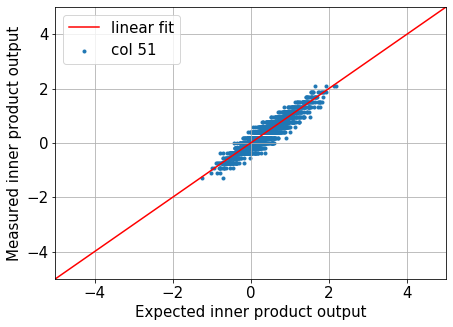

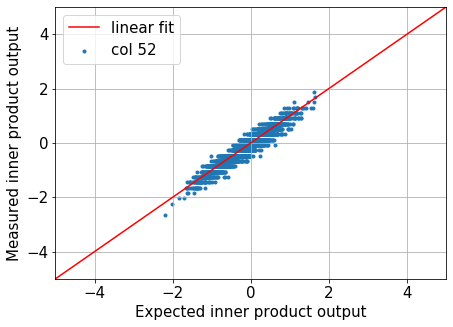

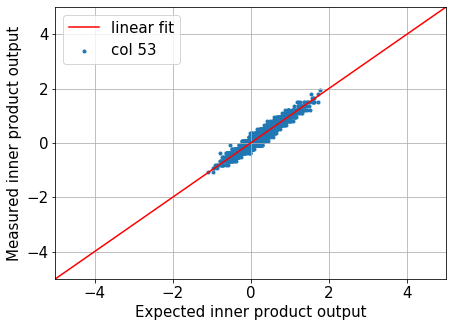

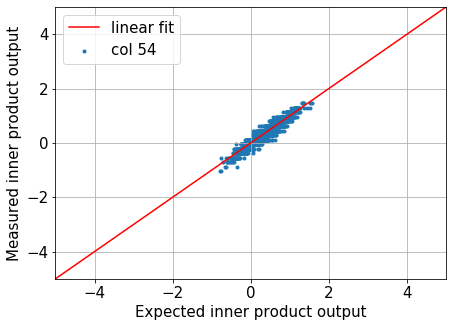

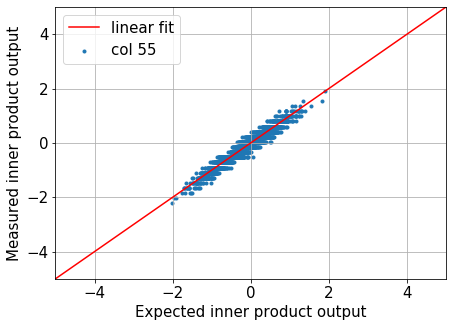

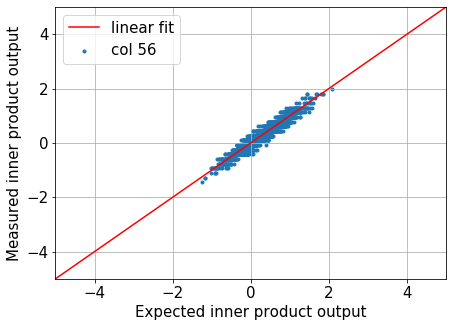

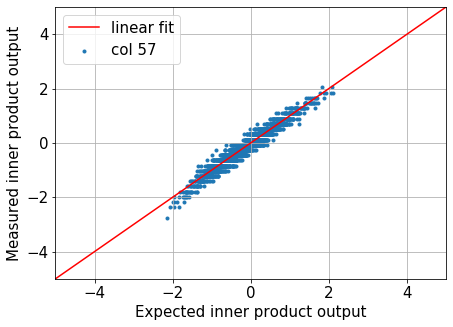

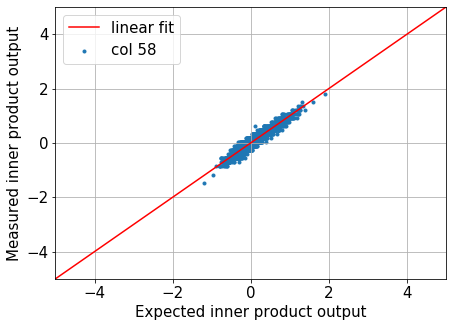

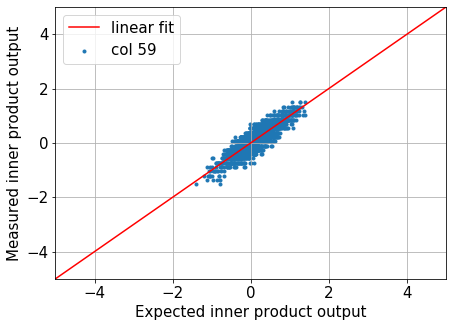

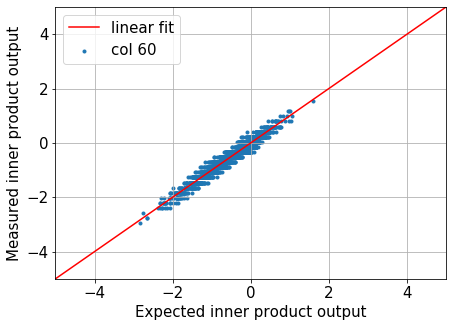

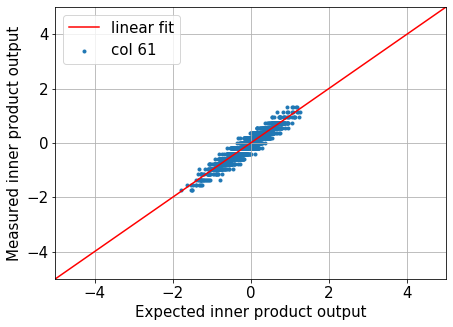

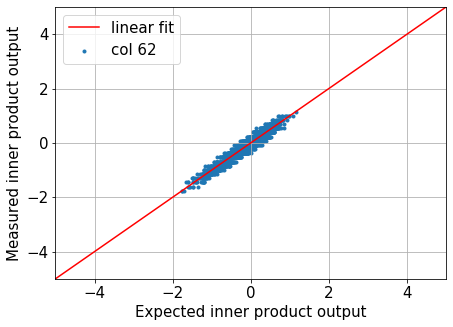

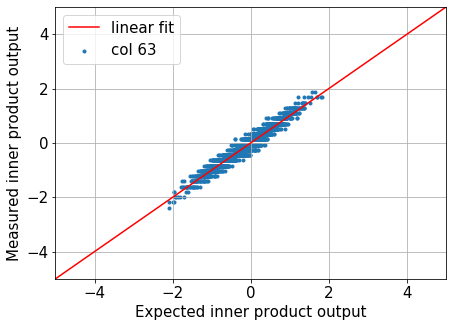

In [3854]:
scatter_sample = np.hstack([np.arange(20), np.arange(1000, 1020), np.arange(1980, 2000)])
for c in range(W.shape[1]):
#     p, res, _, _, _ = np.polyfit(intermediate_output[:, :, :, c].flatten(), out_chip_shift[:, :, :, c].flatten(), 1, full=True)
    y_fit = np.poly1d([1, 0])
#     std = np.sqrt(res/(intermediate_output[:, :, :, c].size-1))
    x = np.arange(-100, 100, 1)

    plt.figure(figsize=(7,5))
    plt.rcParams.update({'font.size': 15})
    ax = plt.subplot(111)
    plt.scatter(intermediate_output[scatter_sample, :, :, c], out_chip_shift[scatter_sample, :, :, c], label='col %d' % c, marker='.')
    plt.plot(x, y_fit(x), 'r', label='linear fit')
    plt.grid()
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel('Expected inner product output')
    plt.ylabel('Measured inner product output')
    plt.legend()

#     print(p[0]) # This is the output scaling factor
#     print(std[0]/p[0])

In [3855]:
# slope_5 = slope
# intercept_5 = intercept
out_chip_shift_5 = (out_chip - intercept) / slope

In [3856]:
out_chip_shift = out_chip_shift_0 + out_chip_shift_1 + out_chip_shift_2 + out_chip_shift_3 + out_chip_shift_4 + out_chip_shift_5

In [3544]:
out_chip_shift = (out_chip - intercept) / slope #(out_chip[0, 0, :, :, :, :] - intercept_0) / slope_0 + (out_chip[1, 0, :, :, :, :] - intercept_1) / slope_1 + (out_chip[2, 0, :, :, :, :] - intercept_2) / slope_2

In [3861]:
DATA_PATH = 'C:\\Users\\Weier Wan\\Documents\\neurram_data\\finetune_all\\'
np.save(DATA_PATH + '%s_single_core' % layer, out_chip_shift)
# np.savez(DATA_PATH + '%s_%d' % (layer, w_index), out_chip_shift=out_chip_shift, slope=slope, intercept=intercept, vpos=vpos, vneg=vneg, pulse_multiplier=pulse_multiplier)

# Evaluate inference accuracy

In [3857]:
def resnet20_finetune(activation_bits, weight_noise_train, weight_noise_test):
    # Build model for finetuning

    layer_input_0 = Input(shape=(16, 16, 32)) # a new input tensor to be able to feed the desired layer
    layer_input_1 = Input(shape=(8, 8, 64))

    # create the new nodes for each layer in the path

#     y = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise')(layer_input_0)
#     y = BatchNormalization(name='batch_normalization')(y)
#     y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant')(layer_input_0)

    # Stack 1, block 1
#     x = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_1')(y)
#     x = BatchNormalization(name='batch_normalization_1')(x)
#     x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_1')(layer_input_1)
#     x = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_2')(x)
#     x = BatchNormalization(name='batch_normalization_2')(x)
#     y = keras.layers.add([y, layer_input_1])
#     y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_2')(layer_input_0)

    # Stack 1, block 2
#     x = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_3')(y)
#     x = BatchNormalization(name='batch_normalization_3')(x)
#     x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_3')(x)
#     x = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_4')(x)
#     x = BatchNormalization(name='batch_normalization_4')(x)
#     y = keras.layers.add([y, layer_input_1])
#     y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_4')(layer_input_0)

    # Stack 1, block 3
#     x = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_5')(y)
#     x = BatchNormalization(name='batch_normalization_5')(x)
#     x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_5')(layer_input_1)
#     x = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_6')(x)
#     x = BatchNormalization(name='batch_normalization_6')(x)
#     y = keras.layers.add([y, layer_input_1])
#     y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_6')(layer_input_0)

    # Stack 2, block 1
#     x = conv2d_noise(32, strides=2, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_7')(y)
#     x = BatchNormalization(name='batch_normalization_7')(x)
#     x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_7')(layer_input_1)
#     x = conv2d_noise(32, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_8')(x)
#     y = conv2d_noise(32, kernel_size=1, strides=2, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_9')(y)
#     x = BatchNormalization(name='batch_normalization_8')(x)
#     y = keras.layers.add([layer_input_0, layer_input_1])
#     y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_8')(layer_input_0)

    # Stack 2, block 2
#     x = conv2d_noise(32, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_10')(y)
#     x = BatchNormalization(name='batch_normalization_9')(x)
#     x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_9')(x)
#     x = conv2d_noise(32, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_11')(x)
#     x = BatchNormalization(name='batch_normalization_10')(x)
#     y = keras.layers.add([y, layer_input_1])
#     y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_10')(layer_input_0)

    # Stack 2, block 3
#     x = conv2d_noise(32, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_12')(y)
#     x = BatchNormalization(name='batch_normalization_11')(x)
#     x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_11')(layer_input_1)
#     x = conv2d_noise(32, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_13')(x)
#     x = BatchNormalization(name='batch_normalization_12')(x)
#     y = keras.layers.add([y, layer_input_1])
    y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_12')(layer_input_0)

    # Stack 3, block 1
#     x = conv2d_noise(64, strides=2, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_14')(y)
#     x = BatchNormalization(name='batch_normalization_13')(x)
#     x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_13')(layer_input_1)
#     x = conv2d_noise(64, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_15')(x)
    y = conv2d_noise(64, kernel_size=1, strides=2, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_16')(y)
#     x = BatchNormalization(name='batch_normalization_14')(x)
    y = keras.layers.add([y, layer_input_1])
    y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_14')(y)

    # Stack 3, block 2
    x = conv2d_noise(64, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_17')(y)
    x = BatchNormalization(name='batch_normalization_15')(x)
    x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_15')(x)
    x = conv2d_noise(64, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_18')(x)
    x = BatchNormalization(name='batch_normalization_16')(x)
    y = keras.layers.add([y, x])
    y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_16')(y)

    # Stack 3, block 3
    x = conv2d_noise(64, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_19')(y)
    x = BatchNormalization(name='batch_normalization_17')(x)
    x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_17')(x)
    x = conv2d_noise(64, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_20')(x)
    x = BatchNormalization(name='batch_normalization_18')(x)
    y = keras.layers.add([y, x])

    y = AveragePooling2D(pool_size=8)(y)
    y = Flatten()(y)
    y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_18')(y)

    outputs = dense_noise(10, activation='softmax', noise_train=weight_noise_train, noise_test=weight_noise_test, name='dense_noise')(y)

    # create the model
    model = Model([layer_input_0, layer_input_1], outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(1e-4),
                  metrics=['accuracy'])
    model.summary()
    return model


def build_model(activation_bits, weight_noise_train, weight_noise_test, weights_map):
    K.clear_session()
    model = resnet20_finetune(activation_bits, weight_noise_train, weight_noise_test)
    for klayer in model.layers:
        if klayer.name in weights_map:
            klayer.set_weights(weights_map[klayer.name])
    return model

In [3858]:
new_model = build_model(3, 0.1, 0.0, weights)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 16, 32)] 0                                            
__________________________________________________________________________________________________
activation_quant_12 (activation (None, 16, 16, 32)   1           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_noise_16 (conv2d_noise)  (None, 8, 8, 64)     2112        activation_quant_12[0][0]        
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8, 8, 64)]   0                                            
______________________________________________________________________________________________

In [3605]:
DATA_PATH = 'C:\\Users\\Weier Wan\\Documents\\neurram_data\\finetune_all\\'

# previous_layer = np.load(DATA_PATH + 'add.npy')

# tmp = np.load(DATA_PATH + 'full_dataset_%s.npz' % 'conv2d_noise_9_0_3b')
# previous_layer = (tmp['out_chip'] - tmp['intercept']) / tmp['slope']

# tmp = np.load(DATA_PATH + 'full_dataset_%s.npz' % 'conv2d_noise_4_1_3b')
# previous_layer += (tmp['out_chip'] - tmp['intercept']) / tmp['slope']

# previous_layer = np.load(DATA_PATH + 'conv2d_noise_9.npy')
current_layer = np.load(DATA_PATH + 'conv2d_noise_13.npy')

In [217]:
previous_layer = nn_np.quantize_rescale(input_sample, 3, relux)

In [3859]:
# Score intermediate input model.
scores = new_model.evaluate([previous_layer, out_chip_shift], y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 6s 606us/sample - loss: 0.4527 - accuracy: 0.8472
Test loss: 0.45265433468818667
Test accuracy: 0.8472


In [3607]:
intermediate_layer_model = keras.Model(inputs=new_model.input,
                                 outputs=new_model.get_layer('add').output)
previous_layer = intermediate_layer_model.predict([previous_layer, current_layer])

In [3860]:
np.save(DATA_PATH + 'add_2_3_single_core', previous_layer)

In [3545]:
np.mean(np.argmax(out_chip_shift, axis=1) == np.argmax(y_test, axis=1))

0.8352